# Policy Briefing Title: Airbnb-and-Multiple-Deprivation-in-London

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfninh, ucfnabh, ucfnwta, ucfnyc0


# Project Overview
This project aims to identify the challenges and opportunities of the social development in London's LSOAs, related to Airbnb operation. 

According to the diversity of social patterns and the developing trend of Airbnb, Airbnb operations in different LSOAs can be instructed accordingly with differential regulatory policy. 

The framework is as follows:

1. **Data Preprocessing**: load data, clean data, manipulate data in a proper format for analysis

2. **Data analysis**: here are 4 stages. 

    2.1. **Spatial distribution of Airbnb activity**: data visualisaition on maps, autocorrelation analysis (Moran'I).
    
    2.2. **Features of areas with different social pattern**: clustering analysis (K-mean), descriptive analysis
    
    2.3. **Airbnb's impact on areas with different social pattern**: regression analysis (linear regression)
    
    2.4. **LSOAs require regulation**: filting LSOAs by selected indexes, visualisation

# Reproduceable Analysis

## 1. Data Preprocessing

### 1.1. Loading Data

In [1]:
#loading package
import pandas as pd

import matplotlib.cm
from matplotlib import colors
import matplotlib.pyplot as plt 
import numpy as np              
import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score

from sklearn.preprocessing import RobustScaler
import sklearn

import os
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.cm as cm
from matplotlib.pyplot import figure   

import statsmodels.formula.api as smf
import statsmodels

#### 1.1.1. Index of deprivation

In [2]:
# read imd data
df = pd.read_csv('https://raw.githubusercontent.com/Fayee23/FSDS_A2/main/London_imd_2019_cleaning.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ls11cd                                     4835 non-null   object 
 1   la11nm                                     4835 non-null   object 
 2   london_imd_rank                            4835 non-null   int64  
 3   london_imd_decile                          4835 non-null   int64  
 4   Index of Multiple Deprivation (IMD) Score  4835 non-null   float64
 5   Income Score (rate)                        4835 non-null   float64
 6   Employment Score (rate)                    4835 non-null   float64
 7   Education, Skills and Training Score       4835 non-null   float64
 8   Health Deprivation and Disability Score    4835 non-null   float64
 9   Crime Score                                4835 non-null   float64
 10  Barriers to Housing and 

ls11cd                la11nm  london_imd_rank  london_imd_decile  \
0  E01000001        City of London             4576                 10   
1  E01000002        City of London             4700                 10   
2  E01000003        City of London             2562                  6   
3  E01000005        City of London             1325                  3   
4  E01000006  Barking and Dagenham             2485                  6   

   Index of Multiple Deprivation (IMD) Score  Income Score (rate)  \
0                                      6.208                0.007   
1                                      5.143                0.034   
2                                     19.402                0.086   
3                                     28.652                0.211   
4                                     19.837                0.117   

   Employment Score (rate)  Education, Skills and Training Score  \
0                    0.010                                 0.024   
1                    0.027                                 0.063   
2                    0.086                                 5.804   
3                    0.136                                22.260   
4                    0.059                                14.798   

   Health Deprivation and Disability Score  Crime Score  \
0                                   -1.654       -2.012   
1                                   -1.115       -2.343   
2                                   -0.102       -1.032   
3                                   -0.121       -1.317   
4                                   -0.359       -0.147   

   Barriers to Housing and Services Score  Living Environment Score  
0                                  29.472                    31.873  
1                                  24.412                    23.084  
2                                  40.103                    40.535  
3                                  39.900                    28.979  
4                                  45.171                    26.888

In [3]:
# from the data information, there is no null value in this data frame
# rename
df.rename(columns = {'ls11cd':'code',
                     'la11nm':'name',
                     'Index of Multiple Deprivation (IMD) Score':'imd',
                     'Income Score (rate)':'income',
                     'Employment Score (rate)':'employment',
                     'Education, Skills and Training Score':'edu_ski_tra',
                     'Health Deprivation and Disability Score':'health_depri',
                     'Crime Score':'crime',
                     'Barriers to Housing and Services Score':'hous_serv',
                     'Living Environment Score':'living_env'}, 
          inplace = True)
df.head()

code                  name  london_imd_rank  london_imd_decile  \
0  E01000001        City of London             4576                 10   
1  E01000002        City of London             4700                 10   
2  E01000003        City of London             2562                  6   
3  E01000005        City of London             1325                  3   
4  E01000006  Barking and Dagenham             2485                  6   

      imd  income  employment  edu_ski_tra  health_depri  crime  hous_serv  \
0   6.208   0.007       0.010        0.024        -1.654 -2.012     29.472   
1   5.143   0.034       0.027        0.063        -1.115 -2.343     24.412   
2  19.402   0.086       0.086        5.804        -0.102 -1.032     40.103   
3  28.652   0.211       0.136       22.260        -0.121 -1.317     39.900   
4  19.837   0.117       0.059       14.798        -0.359 -0.147     45.171   

   living_env  
0      31.873  
1      23.084  
2      40.535  
3      28.979  
4      26.888

#### 1.1.2. Airbnb data

In [4]:
# read airbnb listing data
airbnb = pd.read_csv('https://raw.githubusercontent.com/Fayee23/FSDS_A2/main/data/London-2019-11-listings.csv')
airbnb.head()
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85236 entries, 0 to 85235
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              85236 non-null  object
 1   name                            85236 non-null  object
 2   host_id                         85236 non-null  object
 3   host_name                       85236 non-null  object
 4   neighbourhood_group             85236 non-null  object
 5   neighbourhood                   85236 non-null  object
 6   latitude                        85236 non-null  object
 7   longitude                       85236 non-null  object
 8   room_type                       85236 non-null  object
 9   price                           85236 non-null  object
 10  minimum_nights                  85236 non-null  object
 11  number_of_reviews               85236 non-null  object
 12  last_review                     85236 non-null

/tmp/ipykernel_1957/4212112306.py:2: DtypeWarning: Columns (0,2,6,7,9,10,11,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb = pd.read_csv('https://raw.githubusercontent.com/Fayee23/FSDS_A2/main/data/London-2019-11-listings.csv')


In [5]:
# from the data information, there is no null value in this data frame
# covert to numeric
airbnb['longitude'] = pd.to_numeric(airbnb['longitude'],errors='coerce')
airbnb['latitude'] = pd.to_numeric(airbnb['latitude'],errors='coerce')
airbnb['reviews_per_month'] = pd.to_numeric(airbnb['reviews_per_month'],errors='coerce')
airbnb['price'] = pd.to_numeric(airbnb['price'],errors='coerce')
airbnb['minimum_nights'] = pd.to_numeric(airbnb['minimum_nights'],errors='coerce')
airbnb['number_of_reviews'] = pd.to_numeric(airbnb['number_of_reviews'],errors='coerce')
airbnb['calculated_host_listings_count'] = pd.to_numeric(airbnb['calculated_host_listings_count'],errors='coerce')
airbnb['availability_365'] = pd.to_numeric(airbnb['availability_365'],errors='coerce')

<AxesSubplot:>

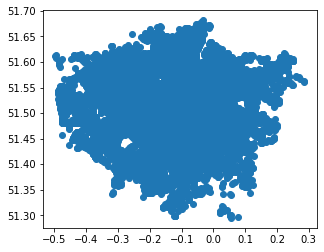

In [6]:
# read location and check the map
point = gpd.GeoDataFrame(
    airbnb, geometry=gpd.points_from_xy(x=airbnb.longitude, y=airbnb.latitude) )
point = point.set_crs(4326)
point.plot()

#### 1.1.3. read LSOA shapefile data

<AxesSubplot:>

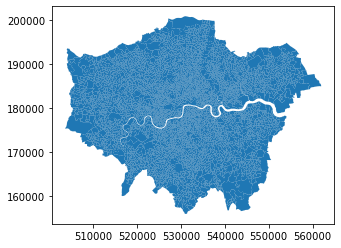

In [7]:
# read shapefile data
LSOA = gpd.read_file("https://github.com/Fayee23/FSDS_A2/blob/main/data/LSOA2011.gpkg?raw=true")  # read shapefile

# calculate area
LSOA['area'] = LSOA.area
# check lsoa shapefile
LSOA.plot(edgecolor="grey", linewidth=.01)

### 1.2. Clean data

In [8]:
df.isnull().sum(axis=0).sort_values(ascending=False)[0:]

code                 0
name                 0
london_imd_rank      0
london_imd_decile    0
imd                  0
income               0
employment           0
edu_ski_tra          0
health_depri         0
crime                0
hous_serv            0
living_env           0
dtype: int64

There is no null value in the data frame.

### 1.3.Manipulate data

#### 1.3.1 join data

In [9]:
# check crs
print(point.crs)
print(LSOA.crs)

epsg:4326
PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [10]:
# reproject crs
LSOA4326  = LSOA.to_crs('epsg:4326')

# join airbnb point and lsoa area
join = gpd.sjoin(point, LSOA4326, predicate='within') 
join.head()

id                                               name    host_id  \
0       9582415  Single/Twin/Double Ensuite near Twickenham Sta...   49602995   
67449   9730457                            Beautiful Room in House   23185644   
69896  16375744       Spacious 4 bedroom house in leafy Twickenham  106792442   
1      23013522    Spacious room with double bed for 2, Twickenham   70374572   
1723   22962647  Cosy single next to Twickenham stadium & Heathrow  165537614   

       host_name neighbourhood_group         neighbourhood  latitude  \
0        Daniela                      Richmond upon Thames  51.44473   
67449     Kaycee                      Richmond upon Thames  51.44392   
69896     Serena                      Richmond upon Thames  51.44346   
1           Monk                                  Hounslow  51.45867   
1723   Francesca                                  Hounslow  51.45836   

       longitude        room_type  price  ...               LAD11NM  \
0       -0.37900     Private room   35.0  ...  Richmond upon Thames   
67449   -0.37378     Private room   16.0  ...  Richmond upon Thames   
69896   -0.36928  Entire home/apt  150.0  ...  Richmond upon Thames   
1       -0.34444     Private room   19.0  ...              Hounslow   
1723    -0.34430     Private room   20.0  ...              Hounslow   

         RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES POPDEN HHOLDS  \
0      E12000007  London      1626      1615         11   39.6    622   
67449  E12000007  London      1626      1615         11   39.6    622   
69896  E12000007  London      1626      1615         11   39.6    622   
1      E12000007  London      1318      1318          0   63.8    479   
1723   E12000007  London      1318      1318          0   63.8    479   

      AVHHOLDSZ           area  
0           2.6  411623.965047  
67449       2.6  411623.965047  
69896       2.6  411623.965047  
1           2.8  210715.524645  
1723        2.8  210715.524645  

[5 rows x 35 columns]

#### 1.3.2. calculate data

In [11]:
join['number'] = 1 # prepare for calculate number of airbnb points by LSOA
join2 = join[['number','LSOA11CD',"price","minimum_nights","reviews_per_month", "calculated_host_listings_count","availability_365"]]
d = {'number':'summary', 'price':'m_price', 'm_nights':'m_minnights','reviews_per_month':'m_monreview', 
     'calculated_host_listings_count':'m_hostlisting','availability_365':'m_avaliable'}

joingroup=join2.groupby('LSOA11CD').agg({'number':'sum', 'price':'mean','minimum_nights':'mean','reviews_per_month':'mean',
                                     'calculated_host_listings_count':'mean','availability_365':'mean'}).rename(columns=d)

joingroup['m_avaliable'] = joingroup['m_avaliable']/365 # calculate Airbnb density by area
joingroup.head()

summary     m_price  minimum_nights  m_monreview  m_hostlisting  \
LSOA11CD                                                                     
E01000001       17  151.176471        7.705882     1.015000      26.411765   
E01000002       10  200.400000        3.800000     1.506667       4.800000   
E01000003        7  139.428571       15.428571     0.305714      13.428571   
E01000005       69  138.478261        3.666667     1.230800      21.405797   
E01000006        5   44.200000        3.000000     0.465000       1.200000   

           m_avaliable  
LSOA11CD                
E01000001     0.514102  
E01000002     0.215890  
E01000003     0.035225  
E01000005     0.300417  
E01000006     0.451507

In [12]:
# rejoin groupby results with shapefile
LSOAairbnb = LSOA4326.merge(joingroup, on='LSOA11CD', how='left')
LSOAairbnb['density'] = LSOAairbnb['summary']/LSOAairbnb['area']
LSOAairbnb.head()

LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  AVHHOLDSZ                                           geometry  \
0  ...        1.7  MULTIPOLYGON (((-0.09729 51.52158, -0.09652 51...   
1  ...        1.7  MULTIPOLYGON (((-0.08813 51.51941, -0.08929 51...   
2  ...        1.5  MULTIPOLYGON (((-0.09679 51.52325, -0.09647 51...   
3  ...        2.1  MULTIPOLYGON (((-0.07323 51.51000, -0.07553 51...   
4  ...        3.1  MULTIPOLYGON (((0.09115 51.53909, 0.09326 51.5...   

            area  summary     m_price  minimum_nights  m_monreview  \
0  133320.768859     17.0  151.176471        7.705882     1.015000   
1  226191.273063     10.0  200.400000        3.800000     1.506667   
2   57302.966528      7.0  139.428571       15.428571     0.305714   
3  190738.760508     69.0  138.478261        3.666667     1.230800   
4  144195.846859      5.0   44.200000        3.000000     0.465000   

   m_hostlisting  m_avaliable   density  
0      26.411765     0.514102  0.000128  
1       4.800000     0.215890  0.000044  
2      13.428571     0.035225  0.000122  
3      21.405797     0.300417  0.000362  
4       1.200000     0.451507  0.000035  

[5 rows x 23 columns]

In [13]:
# save as shapefile
LSOAairbnb.to_file('LSOAairbnb1.shp')  # this file is shared with group members for following analysis
# check saved file
LSOAairbnb = gpd.read_file("LSOAairbnb1.shp")  # read shapefile
LSOAairbnb.head()

/tmp/ipykernel_1957/835518367.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  LSOAairbnb.to_file('LSOAairbnb1.shp')  # this file is shared with group members for following analysis


LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  AVHHOLDSZ           area  summary     m_price  minimum_ni  m_monrevie  \
0  ...        1.7  133320.768859     17.0  151.176471    7.705882    1.015000   
1  ...        1.7  226191.273063     10.0  200.400000    3.800000    1.506667   
2  ...        1.5   57302.966528      7.0  139.428571   15.428571    0.305714   
3  ...        2.1  190738.760508     69.0  138.478261    3.666667    1.230800   
4  ...        3.1  144195.846859      5.0   44.200000    3.000000    0.465000   

   m_hostlist  m_avaliabl   density  \
0   26.411765    0.514102  0.000128   
1    4.800000    0.215890  0.000044   
2   13.428571    0.035225  0.000122   
3   21.405797    0.300417  0.000362   
4    1.200000    0.451507  0.000035   

                                            geometry  
0  POLYGON ((-0.09729 51.52158, -0.09652 51.52027...  
1  POLYGON ((-0.08813 51.51941, -0.08929 51.51752...  
2  POLYGON ((-0.09679 51.52325, -0.09647 51.52282...  
3  POLYGON ((-0.07323 51.51000, -0.07553 51.50974...  
4  POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...  

[5 rows x 23 columns]

## 2. Data analysis

### 2.1. Where is Airbnb activity located, and how is it operated?

#### 2.1.1. plot airbnb density map by LSOA - density & reviews

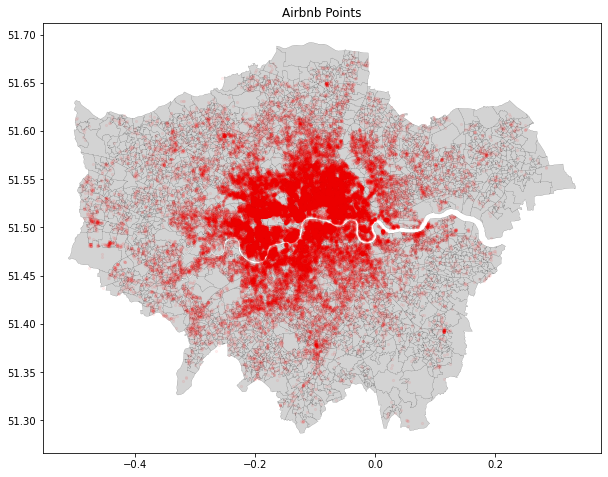

In [14]:
# Airbnb point map

fig, ax = plt.subplots(figsize = (10,10))
LSOAairbnb.to_crs(epsg=4326).plot(ax=ax,edgecolor="black", linewidth=.1, color='lightgrey')
point.plot(ax=ax,  alpha = .05, markersize = 5, color = 'red')
ax.set_title('Airbnb Points')
plt.savefig('Airbnb Points')

Above map indicates a centric distribution of Airbnb in London.

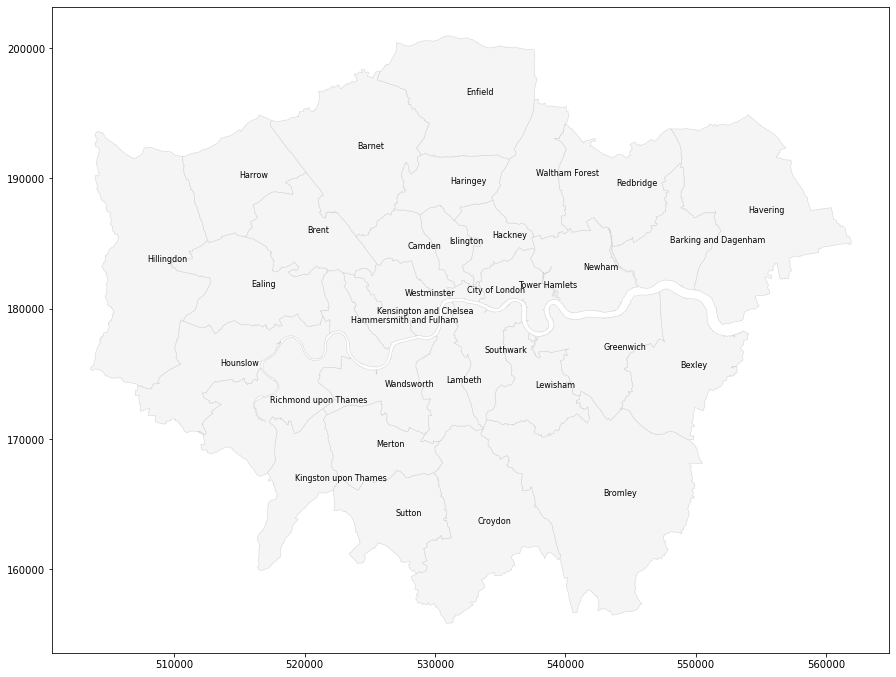

In [15]:
# borough map is presented for later discussion
Borough = gpd.read_file("https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true")
Borough["center"] = Borough["geometry"].centroid
za_points = Borough.copy()
za_points.set_geometry("center", inplace = True)
ax = Borough.plot(figsize = (15, 12), facecolor = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
texts = []
for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["NAME"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

Text(0.5, 0.98, 'Airbnb Density and Monthly Reviews by LSOA in London (2019)')

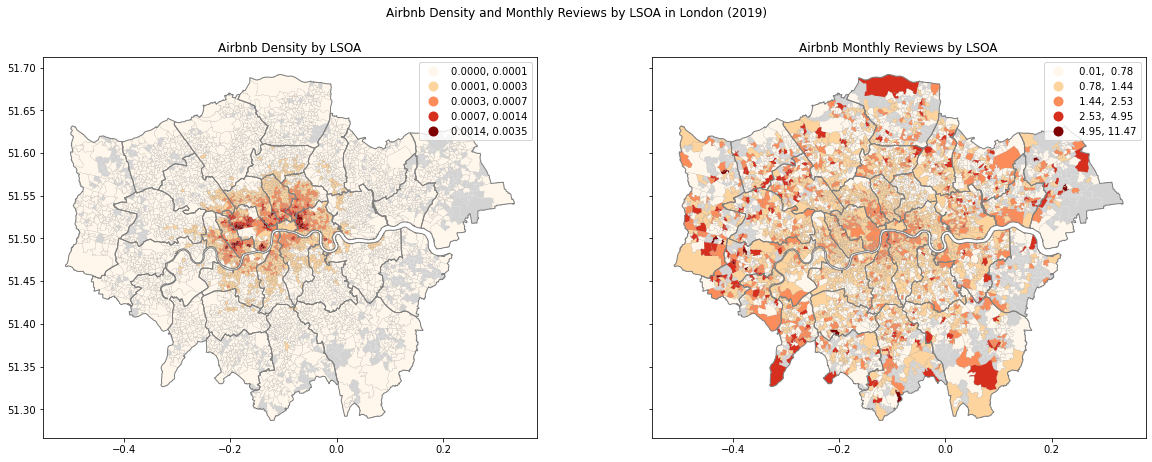

In [16]:
from matplotlib import pyplot
import geopandas
from shapely import geometry

# plot Airbnb Density and Monthly Reviews by LSOA in London (2019)
fig, (ax1, ax2) = pyplot.subplots(ncols=2, figsize = (20,7), sharex=True, sharey=True)

# ax1: Airbnb Density by LSOA
LSOAairbnb.to_crs(epsg=4326).plot(ax=ax1, color='lightgrey')
LSOAairbnb.plot(column = 'density', ax=ax1, cmap = 'OrRd', scheme='natural_breaks', edgecolor="grey", linewidth=.1,
                legend = True, legend_kwds={'loc': 'upper right',  'fmt':"{:.4f}"})
Borough.to_crs(epsg=4326).plot(ax=ax1, facecolor='none', edgecolor="grey",linewidth=1)
ax1.set_title('Airbnb Density by LSOA')

# ax2: Airbnb Monthly Reviews by LSOA
LSOAairbnb.to_crs(epsg=4326).plot(ax=ax2, color='lightgrey')
LSOAairbnb.plot(column = 'm_monrevie', ax=ax2, cmap = 'OrRd', edgecolor="grey", linewidth=.1,
                scheme='natural_breaks', legend = True)
Borough.to_crs(epsg=4326).plot(ax=ax2, facecolor='none', edgecolor="grey",linewidth=1)

ax2.set_title('Airbnb Monthly Reviews by LSOA')

fig.suptitle('Airbnb Density and Monthly Reviews by LSOA in London (2019)')

Considerable differences between airbnb density and monthly reviews is presented in above maps. Although higher density of airbnb is located in the inner boroughs, higher monthly reviews are located in the outer London. This phenomenon suggests potential high rate of vacant Airbnb rooms or differences in reservation durations. To further explore its causes, the distribution of airbnb will be analysed by neighbourhood.

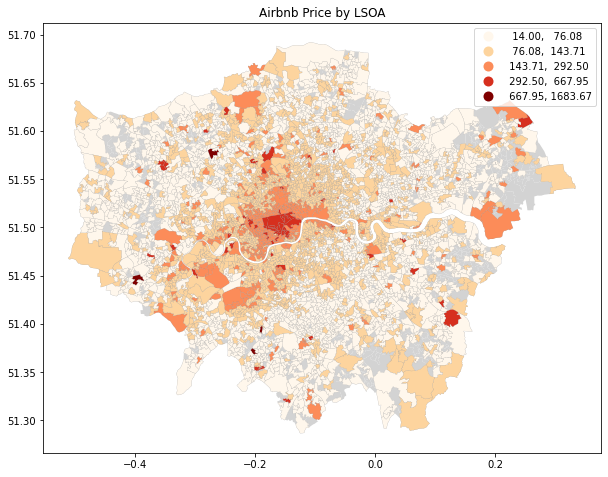

In [17]:
# Airbnb Price by LSOA

fig, ax = plt.subplots(figsize = (10,10))
LSOAairbnb.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
LSOAairbnb.plot(column = 'm_price', ax=ax, cmap = 'OrRd', edgecolor="grey", linewidth=.1 ,
                scheme='natural_breaks', legend = True)
ax.set_title('Airbnb Price by LSOA')
plt.savefig('Airbnb Price by LSOA')

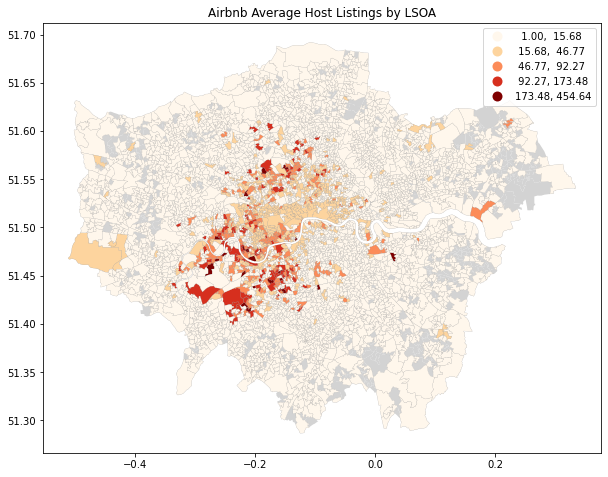

In [18]:
# Airbnb Average Host Listings by LSOA

fig, ax = plt.subplots(figsize = (10,10))
LSOAairbnb.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
LSOAairbnb.plot(column = 'm_hostlist', ax=ax, cmap = 'OrRd', edgecolor="grey", linewidth=.1 ,
                scheme='natural_breaks', legend = True)
ax.set_title('Airbnb Average Host Listings by LSOA')
plt.savefig('Airbnb Average Host Listings by LSOA')

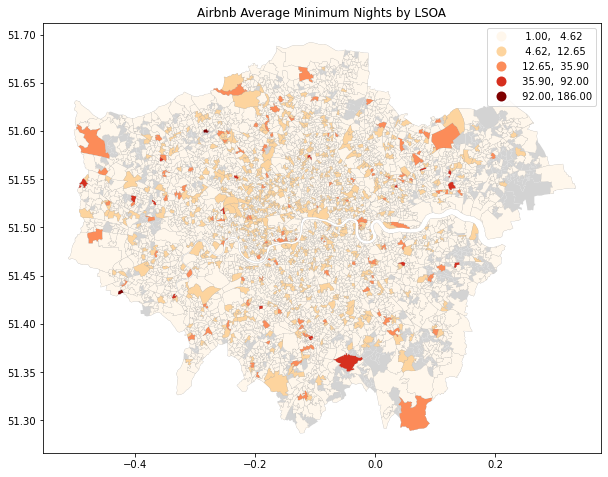

In [19]:
# Airbnb Minimum Nights by LSOA

fig, ax = plt.subplots(figsize = (10,10))
LSOAairbnb.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
LSOAairbnb.plot(column = 'minimum_ni', ax=ax, cmap = 'OrRd', edgecolor="grey", linewidth=.1 ,
                scheme='natural_breaks', legend = True)
ax.set_title('Airbnb Average Minimum Nights by LSOA')
plt.savefig('Airbnb Average Minimum Nights by LSOA')

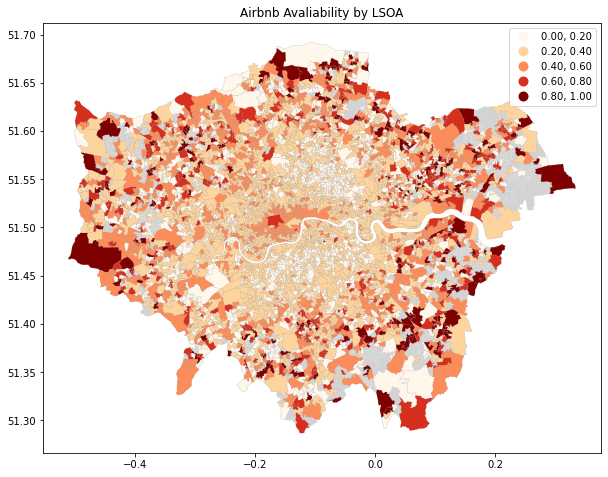

In [20]:
# Airbnb Avaliability in 1 year by LSOA

fig, ax = plt.subplots(figsize = (10,10))
LSOAairbnb.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
LSOAairbnb.plot(column = 'm_avaliabl', ax=ax, cmap = 'OrRd', edgecolor="grey", linewidth=.1 ,
                scheme='equalinterval', legend = True)
ax.set_title('Airbnb Avaliability by LSOA')
plt.savefig('Airbnb Avaliability by LSOA')


Above maps show different features of Airbnb in London. As they are not closely related to the research topic, the result will not be referred in next sections.

#### 2.1.2. Autocorrelation

In [21]:
# loading package
import esda  
import libpysal as lps
import contextily as ctx
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
from pylab import figure, scatter, show
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import plot_moran
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation

In [22]:
# reproject 
LSOAairbnb2 = gpd.read_file('https://github.com/Fayee23/FSDS_A2/blob/main/data/LSOAairbnb.gpkg?raw=true')
LSOAairbnb2 = LSOAairbnb2.to_crs(epsg=4326)


##### Global Moran'I 

In [23]:
#spatial weight matrix
y = LSOAairbnb2['density'].values
w = lps.weights.distance.Kernel.from_dataframe(LSOAairbnb2, fixed=False, k=15)
w.transform = 'r'

In [24]:
moran = Moran(y,w)
moran.I 

0.7874826762787973

The global Moran'I value is about 0.787, which means the spatial pattern of Airbnb listings' density in each LSOA is cluster.

##### Local Moran'I (LISA)

In [25]:
# Local Moran'I value
moran_loc = Moran_Local(y, w)
moran_loc

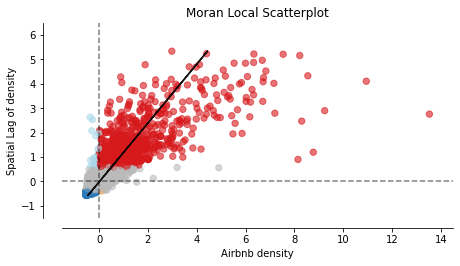

In [26]:
#scatter plot
#fig, ax = plt.subplots(figsize=(10,8)) #, subplot_kw={'aspect': 'equal'}
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Airbnb density')
ax.set_ylabel('Spatial Lag of density')

from matplotlib.pyplot import MultipleLocator
#setting the label 
x_major_locator = MultipleLocator(2)
y_major_locator = MultipleLocator(1) 

ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#setting y axis range
plt.ylim(-1.5,6.5)
#setting y axis range
plt.xlim(-1.5,14.5)

plt.show()

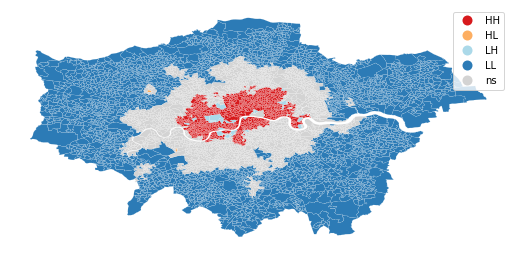

In [27]:
#spatial distribution of cluster area
#LSOAairbnb.to_crs(epsg=2770).plot(ax=ax,edgecolor="black", linewidth=.1, color='lightgrey')

lisa_cluster(moran_loc, LSOAairbnb, p=0.05, figsize = (9,9))

plt.show()

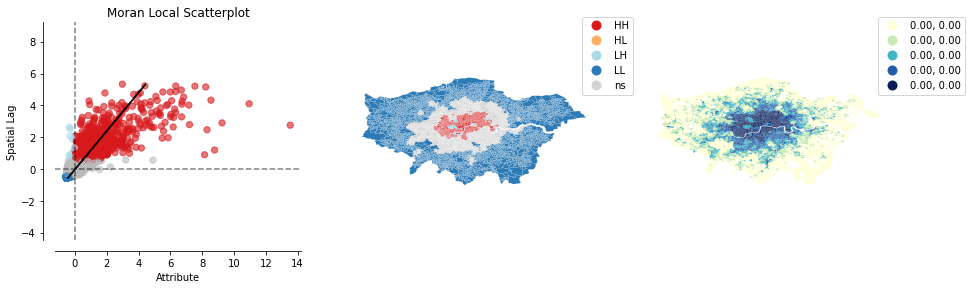

In [28]:
# polt the maps together
plot_local_autocorrelation(moran_loc, LSOAairbnb, 'density')
plt.show()

The LSOAs with high density are cluster in the central of London, surrounding some LSOAs with low density. And the low values of density concentrate on the edge of the city.

### 2.2. What are the features of Airbnb activity in areas with different social patterns?

In [29]:
# select the column used to clustering analysis
data=df[["income","employment","edu_ski_tra","health_depri","crime","hous_serv","living_env"]]
print(data)

      income  employment  edu_ski_tra  health_depri  crime  hous_serv  \
0      0.007       0.010        0.024        -1.654 -2.012     29.472   
1      0.034       0.027        0.063        -1.115 -2.343     24.412   
2      0.086       0.086        5.804        -0.102 -1.032     40.103   
3      0.211       0.136       22.260        -0.121 -1.317     39.900   
4      0.117       0.059       14.798        -0.359 -0.147     45.171   
...      ...         ...          ...           ...    ...        ...   
4830   0.078       0.040        7.808        -0.394 -0.190     40.546   
4831   0.133       0.061        9.232        -0.196  0.214     50.293   
4832   0.184       0.119       17.868         0.879  0.365     37.315   
4833   0.154       0.095        9.758        -0.201 -0.276     45.060   
4834   0.145       0.085        6.379        -0.406  0.679     23.996   

      living_env  
0         31.873  
1         23.084  
2         40.535  
3         28.979  
4         26.888  
...      

In [30]:
# Standardisation
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

data_standardised = data.copy()
for c in data.columns.values:
    data_standardised[c] = mms.fit_transform(data[c].values.reshape(-1,1))
data_standardised.head()

income  employment  edu_ski_tra  health_depri     crime  hous_serv  \
0  0.002320    0.022293     0.000187      0.326228  0.072289   0.355050   
1  0.064965    0.076433     0.000848      0.438871  0.002325   0.275423   
2  0.185615    0.264331     0.098214      0.650575  0.279434   0.522346   
3  0.475638    0.423567     0.377304      0.646604  0.219193   0.519151   
4  0.257541    0.178344     0.250750      0.596865  0.466498   0.602099   

   living_env  
0    0.306702  
1    0.204685  
2    0.407245  
3    0.273110  
4    0.248839

#### examinate the cluster number

In [31]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
scores=[]#silhoutte Score
intra_sum_of_square_list = [] #elbow

max_cluster = 20
clusters = range(2,max_cluster)
X = data_standardised

for k in clusters:
    km = KMeans(n_clusters=k)
    labels=km.fit(X).labels_
    score=metrics.silhouette_score(X,labels)
    scores.append(score) #silhoutte Score
    intra_sum_of_square_list.append(km.inertia_) #elbow

print(clusters)

range(2, 20)


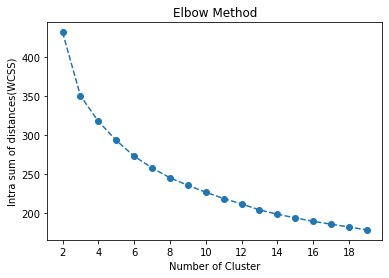

In [32]:
#Elbow
from matplotlib.pyplot import MultipleLocator
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Elbow Method")
ax.set_xlabel("Number of Cluster")
ax.set_ylabel("Intra sum of distances(WCSS)")
plt.plot(clusters,intra_sum_of_square_list,marker = 'o', linestyle = '--')


x_major_locator = MultipleLocator(2)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

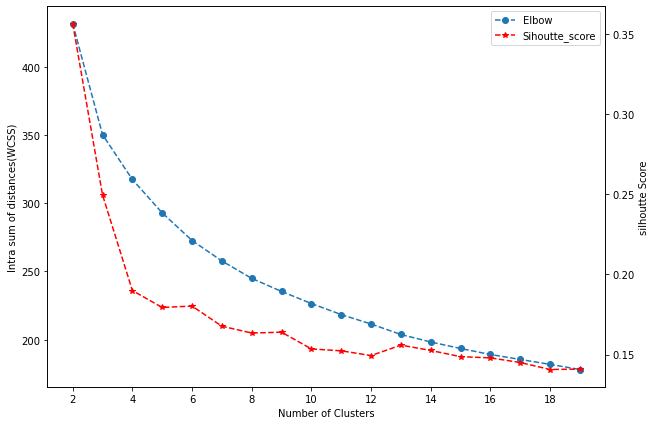

In [33]:
# combine two indicators together!
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()

Elbow, =ax1.plot(clusters,intra_sum_of_square_list, label="Elbow", marker = 'o', linestyle = '--')
Sihoutte_score, =ax2.plot(clusters, scores,label="Sihoutte_score", color='red', marker = '*', linestyle = '--')

ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Intra sum of distances(WCSS)")
ax2.set_ylabel('silhoutte Score')

x_major_locator = MultipleLocator(2)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(x_major_locator)


#legend
legend = ax1.legend(handles=[Elbow,Sihoutte_score], loc='upper right')

The cluster number with highest Silhoutte Score is two, but it defeats the purpose of clustering in the first place. In the absence of a compelling reason to group it into 2 clusters, let's have a closer look at the next maximum silhouetted score and choose 3 as the cluster number.

#### final clustering

In [34]:
# 3 clusters
num_clusters = 3
random_state_seed = 100
kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(data_standardised)

print(kmeans_output) 

clustering_ids_kmeans = kmeans_output.labels_

print(clustering_ids_kmeans)

# combine the clustering IDs to the dataframe
data3 = df.assign(cluster_id = clustering_ids_kmeans)

#rename the lable for map
cluster_class={0:'1',1:'2',2:'3'}
cluster_class
data3['cluster_names'] = data3['cluster_id'].map(cluster_class)
data3

#Have a look at the result:
print(data3)

KMeans(n_clusters=3, random_state=100)
[2 2 0 ... 1 0 0]
           code                  name  london_imd_rank  london_imd_decile  \
0     E01000001        City of London             4576                 10   
1     E01000002        City of London             4700                 10   
2     E01000003        City of London             2562                  6   
3     E01000005        City of London             1325                  3   
4     E01000006  Barking and Dagenham             2485                  6   
...         ...                   ...              ...                ...   
4830  E01033742             Greenwich             3538                  8   
4831  E01033743             Greenwich             2347                  5   
4832  E01033744             Greenwich             1235                  3   
4833  E01033745             Greenwich             2184                  5   
4834  E01033746             Greenwich             2227                  5   

         imd  inco

#### Map Clusters

In [35]:
joined_m = LSOAairbnb.merge(data3,left_on = 'LSOA11CD', right_on ='code')
joined_m.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LSOA11CD           4835 non-null   object  
 1   LSOA11NM           4835 non-null   object  
 2   MSOA11CD           4835 non-null   object  
 3   MSOA11NM           4835 non-null   object  
 4   LAD11CD            4835 non-null   object  
 5   LAD11NM            4835 non-null   object  
 6   RGN11CD            4835 non-null   object  
 7   RGN11NM            4835 non-null   object  
 8   USUALRES           4835 non-null   int64   
 9   HHOLDRES           4835 non-null   int64   
 10  COMESTRES          4835 non-null   int64   
 11  POPDEN             4835 non-null   float64 
 12  HHOLDS             4835 non-null   int64   
 13  AVHHOLDSZ          4835 non-null   float64 
 14  area               4835 non-null   float64 
 15  summary            4469 non-null   float64 
 16

In [36]:
# handle missing value
joined_m.isnull().sum(axis=0).sort_values(ascending=False)[0:]

m_monrevie           567
density              366
m_hostlist           366
minimum_ni           366
m_price              366
summary              366
m_avaliabl           366
edu_ski_tra            0
employment             0
income                 0
health_depri           0
london_imd_decile      0
london_imd_rank        0
name                   0
code                   0
crime                  0
hous_serv              0
living_env             0
geometry               0
cluster_id             0
imd                    0
LSOA11CD               0
LSOA11NM               0
area                   0
AVHHOLDSZ              0
HHOLDS                 0
POPDEN                 0
COMESTRES              0
HHOLDRES               0
USUALRES               0
RGN11NM                0
RGN11CD                0
LAD11NM                0
LAD11CD                0
MSOA11NM               0
MSOA11CD               0
cluster_names          0
dtype: int64

In [37]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import geopandas
from shapely import geometry

<AxesSubplot:>

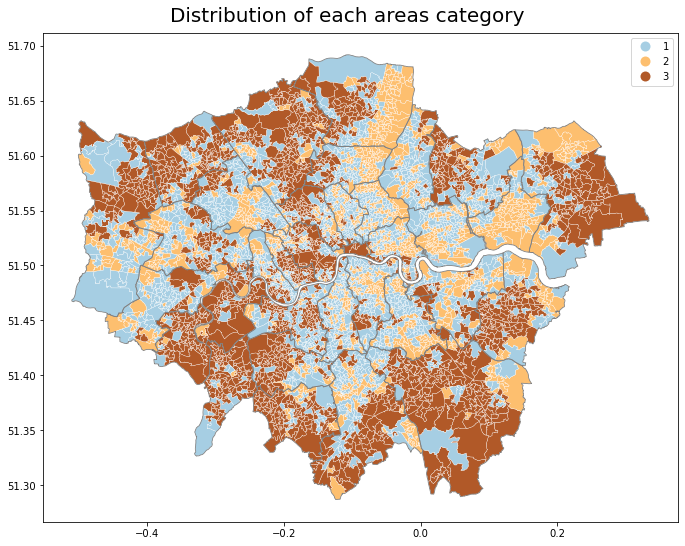

In [38]:
Borough = gpd.read_file("https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true")

fig, ax = plt.subplots(1,1, figsize=(15,9))
fig.suptitle(f"Distribution of each areas category", fontsize=20, y=0.92)
joined_m.plot(ax=ax, column='cluster_names',legend=True, cmap='Paired', edgecolor="white", linewidth=.3)
Borough.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor="grey",linewidth=0.8)

In [39]:
df3=data3[['income', 'employment', 'edu_ski_tra', 'health_depri', 'crime', 'hous_serv', 'living_env', 'cluster_names']]

#### descriptive analysis of each cluster

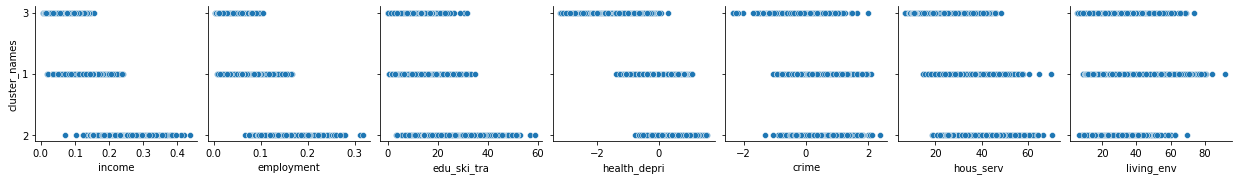

In [40]:
import seaborn as sns
sns.pairplot(df3, y_vars='cluster_names')

In [41]:
joined = joined_m.drop(columns= 'cluster_id')
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LSOA11CD           4835 non-null   object  
 1   LSOA11NM           4835 non-null   object  
 2   MSOA11CD           4835 non-null   object  
 3   MSOA11NM           4835 non-null   object  
 4   LAD11CD            4835 non-null   object  
 5   LAD11NM            4835 non-null   object  
 6   RGN11CD            4835 non-null   object  
 7   RGN11NM            4835 non-null   object  
 8   USUALRES           4835 non-null   int64   
 9   HHOLDRES           4835 non-null   int64   
 10  COMESTRES          4835 non-null   int64   
 11  POPDEN             4835 non-null   float64 
 12  HHOLDS             4835 non-null   int64   
 13  AVHHOLDSZ          4835 non-null   float64 
 14  area               4835 non-null   float64 
 15  summary            4469 non-null   float64 
 16

In [42]:
joined = joined.replace(0, np.nan)# replace 0 to nan
# handle missing value
joined.isnull().sum(axis=0).sort_values(ascending=False)[0:]


COMESTRES            2838
m_monrevie            567
m_avaliabl            479
m_hostlist            366
minimum_ni            366
m_price               366
density               366
summary               366
crime                   3
health_depri            3
name                    0
geometry                0
code                    0
living_env              0
london_imd_rank         0
hous_serv               0
imd                     0
income                  0
employment              0
edu_ski_tra             0
london_imd_decile       0
LSOA11CD                0
LSOA11NM                0
area                    0
AVHHOLDSZ               0
HHOLDS                  0
POPDEN                  0
HHOLDRES                0
USUALRES                0
RGN11NM                 0
RGN11CD                 0
LAD11NM                 0
LAD11CD                 0
MSOA11NM                0
MSOA11CD                0
cluster_names           0
dtype: int64

In [43]:
joined.drop(joined[joined.m_monrevie.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.m_avaliabl.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.minimum_ni.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.m_price.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.summary.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.density.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.m_hostlist.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.crime.isna()].index.array, axis=0, inplace=True)
joined.drop(joined[joined.health_depri.isna()].index.array, axis=0, inplace=True)


In [44]:
# check the result
joined.isnull().sum(axis=0).sort_values(ascending=False)[0:]

COMESTRES            2393
LSOA11CD                0
m_hostlist              0
density                 0
geometry                0
code                    0
name                    0
london_imd_rank         0
london_imd_decile       0
imd                     0
income                  0
employment              0
edu_ski_tra             0
health_depri            0
crime                   0
hous_serv               0
living_env              0
m_avaliabl              0
m_monrevie              0
LSOA11NM                0
USUALRES                0
MSOA11CD                0
MSOA11NM                0
LAD11CD                 0
LAD11NM                 0
RGN11CD                 0
RGN11NM                 0
HHOLDRES                0
minimum_ni              0
POPDEN                  0
HHOLDS                  0
AVHHOLDSZ               0
area                    0
summary                 0
m_price                 0
cluster_names           0
dtype: int64

In [45]:
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4196 entries, 0 to 4834
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LSOA11CD           4196 non-null   object  
 1   LSOA11NM           4196 non-null   object  
 2   MSOA11CD           4196 non-null   object  
 3   MSOA11NM           4196 non-null   object  
 4   LAD11CD            4196 non-null   object  
 5   LAD11NM            4196 non-null   object  
 6   RGN11CD            4196 non-null   object  
 7   RGN11NM            4196 non-null   object  
 8   USUALRES           4196 non-null   int64   
 9   HHOLDRES           4196 non-null   int64   
 10  COMESTRES          1803 non-null   float64 
 11  POPDEN             4196 non-null   float64 
 12  HHOLDS             4196 non-null   int64   
 13  AVHHOLDSZ          4196 non-null   float64 
 14  area               4196 non-null   float64 
 15  summary            4196 non-null   float64 
 16

In [46]:
# slipt data by cluster_id
clu0 = joined[joined['cluster_names']=='1']
clu0.info()

clu1 = joined[joined['cluster_names']=='2']
clu1.info()

clu2 = joined[joined['cluster_names']=='3']
clu2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1692 entries, 2 to 4834
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LSOA11CD           1692 non-null   object  
 1   LSOA11NM           1692 non-null   object  
 2   MSOA11CD           1692 non-null   object  
 3   MSOA11NM           1692 non-null   object  
 4   LAD11CD            1692 non-null   object  
 5   LAD11NM            1692 non-null   object  
 6   RGN11CD            1692 non-null   object  
 7   RGN11NM            1692 non-null   object  
 8   USUALRES           1692 non-null   int64   
 9   HHOLDRES           1692 non-null   int64   
 10  COMESTRES          790 non-null    float64 
 11  POPDEN             1692 non-null   float64 
 12  HHOLDS             1692 non-null   int64   
 13  AVHHOLDSZ          1692 non-null   float64 
 14  area               1692 non-null   float64 
 15  summary            1692 non-null   float64 
 16

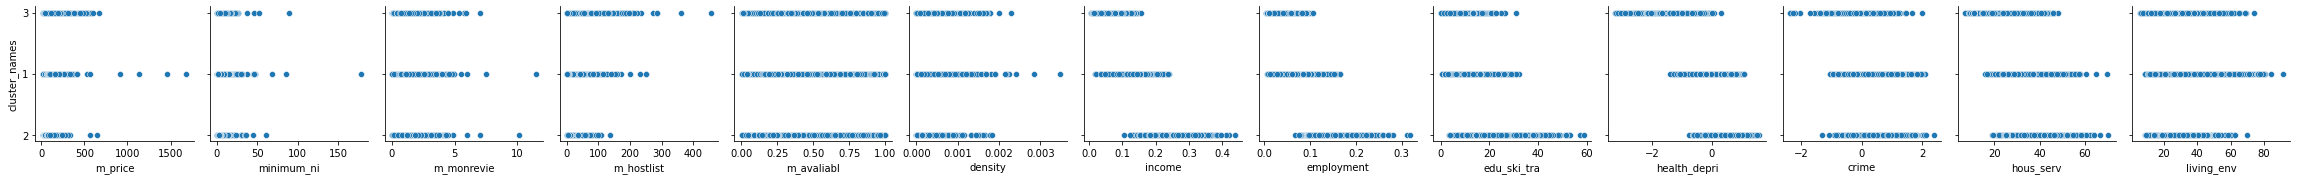

In [47]:
joined_desc = joined[['m_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density',
                      'income','employment','edu_ski_tra','health_depri','crime','hous_serv','living_env','cluster_names']]

import seaborn as sns
sns.pairplot(joined_desc, y_vars='cluster_names')

In [48]:
clu0_desc = clu0[['m_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density',
                      'income','employment','edu_ski_tra','health_depri','crime','hous_serv','living_env']]
clu0_desc.describe()

m_price   minimum_ni   m_monrevie   m_hostlist   m_avaliabl  \
count  1692.000000  1692.000000  1692.000000  1692.000000  1692.000000   
mean     88.580253     4.119815     1.127095    13.485155     0.337341   
std      77.515826     6.479593     0.745093    25.404063     0.181051   
min      15.000000     1.000000     0.030000     1.000000     0.001826   
25%      54.825000     2.111111     0.699688     1.500000     0.212276   
50%      76.729236     2.894177     1.002146     2.750000     0.304690   
75%     105.116538     4.242438     1.377031    12.437500     0.425049   
max    1683.666667   178.500000    11.470000   251.000000     1.000000   

            density       income   employment  edu_ski_tra  health_depri  \
count  1.692000e+03  1692.000000  1692.000000  1692.000000   1692.000000   
mean   1.862377e-04     0.136173     0.084987    10.879567     -0.188787   
std    2.942344e-04     0.034249     0.022961     5.657398      0.394624   
min    6.978778e-08     0.018000     0.006000     0.492000     -1.401000   
25%    2.274423e-05     0.112000     0.069000     6.557000     -0.457000   
50%    7.665423e-05     0.134000     0.083000    10.371500     -0.186000   
75%    2.345869e-04     0.161000     0.101000    14.635750      0.070000   
max    3.475090e-03     0.240000     0.166000    32.243000      1.082000   

             crime    hous_serv   living_env  
count  1692.000000  1692.000000  1692.000000  
mean      0.429424    33.309366    34.302173  
std       0.468228     7.968468    10.898429  
min      -1.041000    15.758000     8.485000  
25%       0.129750    27.313000    26.949500  
50%       0.412000    32.031500    33.218500  
75%       0.730750    38.361750    40.273250  
max       2.099000    69.884000    91.602000

In [49]:
clu1_desc = clu1[['m_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density',
                      'income','employment','edu_ski_tra','health_depri','crime','hous_serv','living_env']]
clu1_desc.describe()

m_price   minimum_ni   m_monrevie   m_hostlist   m_avaliabl  \
count  1130.000000  1130.000000  1130.000000  1130.000000  1130.000000   
mean     71.524000     3.561975     1.165048     7.753847     0.368249   
std      42.801493     4.020221     0.785581    14.282291     0.202885   
min      16.000000     1.000000     0.010000     1.000000     0.000913   
25%      46.520833     1.924123     0.675000     1.337500     0.229893   
50%      64.500000     2.639610     1.016098     2.083333     0.331507   
75%      85.716883     3.817026     1.469167     6.482639     0.472055   
max     650.000000    61.200000    10.100000   137.545455     1.000000   

            density       income   employment  edu_ski_tra  health_depri  \
count  1.130000e+03  1130.000000  1130.000000  1130.000000   1130.000000   
mean   1.479345e-04     0.234211     0.146388    23.925094      0.290858   
std    2.261170e-04     0.045989     0.033514     8.331681      0.381644   
min    3.990270e-07     0.104000     0.066000     3.484000     -0.766000   
25%    1.725309e-05     0.201250     0.123000    17.969750      0.025250   
50%    5.406043e-05     0.229000     0.143000    22.754000      0.296000   
75%    1.965667e-04     0.263000     0.166000    28.866750      0.554750   
max    1.819540e-03     0.437000     0.317000    58.976000      1.570000   

             crime    hous_serv   living_env  
count  1130.000000  1130.000000  1130.000000  
mean      0.611879    38.582411    29.387297  
std       0.467421     8.058761     8.597121  
min      -1.317000    18.763000     8.763000  
25%       0.314000    32.597000    23.515500  
50%       0.605000    38.465000    29.207000  
75%       0.902750    44.306750    34.562250  
max       2.377000    70.456000    69.793000

In [50]:
clu2_desc = clu2[['m_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density',
                      'income','employment','edu_ski_tra','health_depri','crime','hous_serv','living_env']]
clu2_desc.describe()

m_price  minimum_ni   m_monrevie   m_hostlist   m_avaliabl  \
count  1374.000000  1374.00000  1374.000000  1374.000000  1374.000000   
mean    102.989266     3.71335     1.074559    19.289035     0.371860   
std      77.052180     4.41847     0.743380    40.322579     0.204652   
min      17.000000     1.00000     0.020000     1.000000     0.002740   
25%      52.500000     1.87500     0.614308     1.250000     0.224658   
50%      83.775000     2.65336     0.931254     2.000000     0.337694   
75%     126.220833     4.00000     1.334534    15.002727     0.480822   
max     667.947368    90.00000     6.980000   454.636364     1.000000   

            density       income   employment  edu_ski_tra  health_depri  \
count  1.374000e+03  1374.000000  1374.000000  1374.000000   1374.000000   
mean   1.099140e-04     0.062164     0.043710     4.960678     -1.110509   
std    2.328353e-04     0.027411     0.017421     4.547839      0.543266   
min    1.085221e-07     0.006000     0.003000     0.013000     -3.215000   
25%    9.003733e-06     0.041000     0.032000     1.517000     -1.403500   
50%    2.575249e-05     0.060000     0.043000     3.470000     -1.035000   
75%    9.997122e-05     0.080000     0.055000     6.960500     -0.731250   
max    2.299911e-03     0.156000     0.105000    30.760000      0.293000   

             crime    hous_serv   living_env  
count  1374.000000  1374.000000  1374.000000  
mean     -0.134627    24.128440    26.558050  
std       0.491221     6.869319    10.510714  
min      -2.354000     6.910000     5.450000  
25%      -0.445500    19.416250    18.661500  
50%      -0.140500    23.692500    25.242500  
75%       0.185000    28.554500    32.750000  
max       1.982000    48.142000    73.954000

The second category sees relatively high scores in a series of deprivation indexes, except for the living environment index, while the third category has the lowest score of these deprivation indexes.

It is suggested that most of dwellers living in the second category of areas suffer from different aspects of deprivation and those living in the first category are in deprived living environment particularly, which need to be focused on. Again, the conditions of those communities in the third category are better, which leads to the highest price of Airbnb listings and the largest number of listings a host has in these areas. It is noticeable that the density of Airbnb listings in the third category is lowest, which means the hosts in these communities are extremely wealthy and own a great number of properties.  

Thereby, the communities in these three categories can be defined as partially deprived areas, most deprived areas and least deprived areas respectively. 

### 2.3. Is Airbnb’s impact on society reflected in deprivation by areas with different social patterns? 

#### 2.3.1. Category 1: partially deprived area

##### Select both independent variables and dependent variables

In [51]:
df_clu0=clu0[['imd','income','employment','edu_ski_tra','health_depri','crime','hous_serv','living_env',
                   'm_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density']]

##### Correlation

In [52]:
# Show the correlation of variables
corr = df_clu0.corr()
corr.style.background_gradient(cmap='coolwarm')

With the index of "living_env", the coefficient of m_avaliabl and density are relatively higher, therefore, these two independent vairiables are selected to build the model.

##### VIF

In [53]:
df_clu0_living_env=clu0[['living_env','m_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density']]

# Check VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break
    return df

df_selected_VIF_living_env = drop_column_using_vif_(df_clu0_living_env.drop('living_env', axis=1))
print("The columns remaining after VIF selection are:")
print(df_selected_VIF_living_env.columns)

The columns remaining after VIF selection are:
Index(['m_price', 'minimum_ni', 'm_monrevie', 'm_hostlist', 'm_avaliabl',
       'density'],
      dtype='object')


VIF is used to solve the multicollinearity

##### Multiple Linear Regression of all independent variables

In [54]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

# Show multiple linear regression
model_living_env = sm.OLS(endog=df_clu0_living_env[['living_env']], exog=sm.add_constant(df_selected_VIF_living_env)).fit()
model_living_env.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             living_env   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     59.80
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           2.58e-67
Time:                        15:07:55   Log-Likelihood:                -6278.6
No. Observations:                1692   AIC:                         1.257e+04
Df Residuals:                    1685   BIC:                         1.261e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.6242      0.708     48.906      0.000      33.236      36.013
m_price        0.0099      0.003      3.045      0.002       0.004       0.016
minimum_ni     0.0272      0.037      0.728      0.467      -0.046       0.100
m_monrevie    -0.1240      0.327     -0.380      0.704      -0.764       0.516
m_hostlist     0.0021      0.010      0.209      0.835      -0.018       0.022
m_avaliabl   -10.4700      1.358     -7.709      0.000     -13.134      -7.806
density      1.25e+04    866.017     14.436      0.000    1.08e+04    1.42e+04
==============================================================================
Omnibus:                      213.113   Durbin-Watson:                   1.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.791
Skew:                           0.810   Prob(JB):                     1.68e-84
Kurtosis:                       4.687   Cond. No.                     4.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared is 0.173 which shows 17.3% explaining the model. The p values of minimum_ni, m_monrevie and m_hostlist are larger than 0.05 and the p values of m_price, m_avaliabl and density are lower than 0.05. There are relationships between m_price, m_avaliabl, density and living environment. 

##### Multiple Linear Regression in social perspective

In [55]:
# As the p value of minimum_ni, m_monrevie, m_monrevie are lower than 0.05, these variables are dropeed.
model_liv = sm.formula.ols(' living_env ~ m_avaliabl + density', data=df_clu0_living_env).fit()
model_liv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             living_env   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     173.3
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           3.42e-69
Time:                        15:07:55   Log-Likelihood:                -6284.0
No. Observations:                1692   AIC:                         1.257e+04
Df Residuals:                    1689   BIC:                         1.259e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.4460      0.548     64.670      0.000      34.371      36.521
m_avaliabl   -10.6596      1.341     -7.950      0.000     -13.290      -8.030
density     1.317e+04    825.083     15.957      0.000    1.15e+04    1.48e+04
==============================================================================
Omnibus:                      210.448   Durbin-Watson:                   1.417
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.204
Skew:                           0.807   Prob(JB):                     2.03e-82
Kurtosis:                       4.653   Cond. No.                     3.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

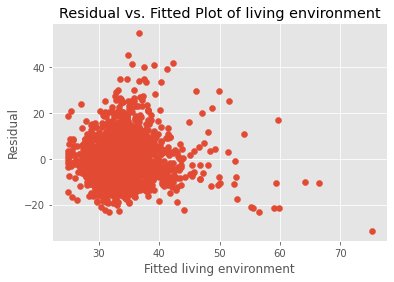

In [56]:
# Residual figure with fitted Plot of living environment
plt.scatter(model_liv.fittedvalues, model_liv.resid)
plt.xlabel('Fitted living environment')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of living environment')
plt.show()

#### 2.3.2. Category 2: most deprived area

#### preparations for regression analysis

In [57]:
# read category 2 data
category2 = clu1 # it was selected based on cluster id and na values were dropped
# drop irrelevant columns
category2 = category2.drop(['LSOA11NM','MSOA11CD','MSOA11NM','LAD11CD','LAD11NM','RGN11CD','RGN11NM','area',
                            'summary','code','name','london_imd_rank','london_imd_decile','geometry','cluster_names'], axis=1)
# check 
category2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 3 to 4832
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LSOA11CD      1130 non-null   object 
 1   USUALRES      1130 non-null   int64  
 2   HHOLDRES      1130 non-null   int64  
 3   COMESTRES     425 non-null    float64
 4   POPDEN        1130 non-null   float64
 5   HHOLDS        1130 non-null   int64  
 6   AVHHOLDSZ     1130 non-null   float64
 7   m_price       1130 non-null   float64
 8   minimum_ni    1130 non-null   float64
 9   m_monrevie    1130 non-null   float64
 10  m_hostlist    1130 non-null   float64
 11  m_avaliabl    1130 non-null   float64
 12  density       1130 non-null   float64
 13  imd           1130 non-null   float64
 14  income        1130 non-null   float64
 15  employment    1130 non-null   float64
 16  edu_ski_tra   1130 non-null   float64
 17  health_depri  1130 non-null   float64
 18  crime         1130 non-null 

In [58]:
# handle missing value
category2.isnull().sum(axis=0).sort_values(ascending=False)[0:]

COMESTRES       705
LSOA11CD          0
m_avaliabl        0
hous_serv         0
crime             0
health_depri      0
edu_ski_tra       0
employment        0
income            0
imd               0
density           0
m_hostlist        0
USUALRES          0
m_monrevie        0
minimum_ni        0
m_price           0
AVHHOLDSZ         0
HHOLDS            0
POPDEN            0
HHOLDRES          0
living_env        0
dtype: int64

Among all the features of neighbourhoods in this category, we can find high values in the income, employment, crime, and housing serving deprivation index. Airbnb in these areas had low airbnb price, low minimuns nights, high month reviews, low hostlisting number, relatively high availability, and relatively high density

##### correlation matrix

In [59]:
# what is the Pearson correlation between IMD and Airbnb?
corr = category2.corr()
corr.style.background_gradient(cmap='coolwarm')

moderate positive correlationship:

    airbnb density - population density & m_hostlist & living_env

    average housinghold - edu_ski_tra & hous_serv 


moderate negative correlationship:

    airbnb density - edu_ski_tra & hous_serv & average housinghold

    average housinghold - employment

##### log transformation

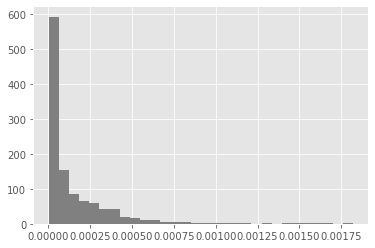

In [60]:
# density histogram
x0 = category2.density
bins = 30
plt.hist(x0 , bins, color = 'grey')
plt.show()

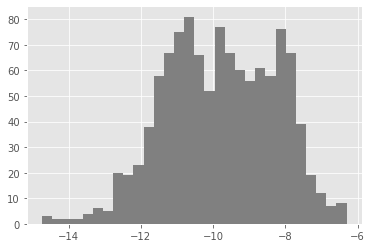

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 3 to 4832
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LSOA11CD      1130 non-null   object 
 1   USUALRES      1130 non-null   int64  
 2   HHOLDRES      1130 non-null   int64  
 3   COMESTRES     425 non-null    float64
 4   POPDEN        1130 non-null   float64
 5   HHOLDS        1130 non-null   int64  
 6   AVHHOLDSZ     1130 non-null   float64
 7   m_price       1130 non-null   float64
 8   minimum_ni    1130 non-null   float64
 9   m_monrevie    1130 non-null   float64
 10  m_hostlist    1130 non-null   float64
 11  m_avaliabl    1130 non-null   float64
 12  density       1130 non-null   float64
 13  imd           1130 non-null   float64
 14  income        1130 non-null   float64
 15  employment    1130 non-null   float64
 16  edu_ski_tra   1130 non-null   float64
 17  health_depri  1130 non-null   float64
 18  crime         1130 non-null 

In [61]:
# log transformation

logD = np.log(category2['density'])
category2['logD']=logD
# log density histogram
x0 = category2.logD
bins = 30
plt.hist(x0 , bins, color = 'grey')
plt.show()
category2.info()

##### residual plots

In [62]:
# calculate regression parameters
rle = smf.ols(formula='living_env ~ logD', data=category2).fit() # A. Y:airbnb density ~ X:living_env
rhs = smf.ols(formula='hous_serv ~ logD', data=category2).fit() # B. Y:airbnb density ~ X:hous_serv
redu = smf.ols(formula='edu_ski_tra ~ logD', data=category2).fit() # C. Y:airbnb density ~ X:edu_ski_tra
rhd = smf.ols(formula='health_depri ~ logD', data=category2).fit() # D. Y:airbnb density ~ X:health_depri

Text(0.5, 0.98, 'Residuals - IMD sub-index and Airbnb Density')

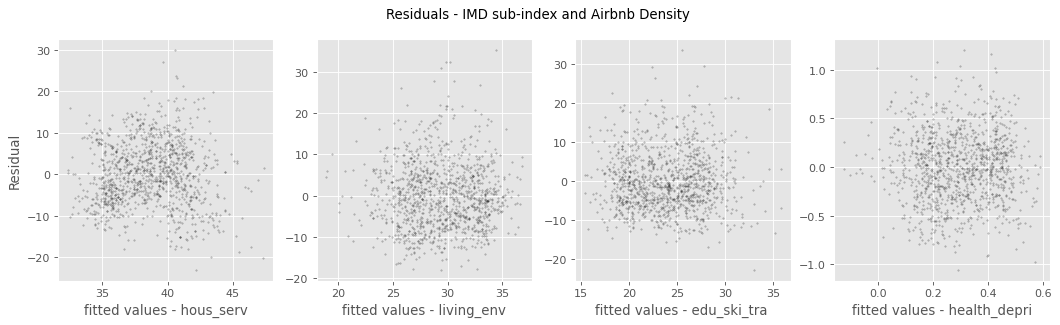

In [63]:
# plot residuals
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=80, sharex=False, sharey=False)

axes[1].scatter(rle.fittedvalues, rle.resid,s = 2, alpha = 0.2, color = 'k')
axes[1].set_xlabel( 'fitted values - living_env')

axes[0].scatter(rhs.fittedvalues, rhs.resid,s = 2, alpha = 0.2, color = 'k')
axes[0].set_xlabel( 'fitted values - hous_serv')
axes[0].set_ylabel( 'Residual')

axes[2].scatter(redu.fittedvalues, redu.resid,s = 2, alpha = 0.2, color = 'k')
axes[2].set_xlabel( 'fitted values - edu_ski_tra ')

axes[-1].scatter(rhd.fittedvalues, rhd.resid,s = 2, alpha = 0.2, color = 'k')
axes[-1].set_xlabel('fitted values - health_depri')

fig.suptitle('Residuals - IMD sub-index and Airbnb Density')

Residual plot show random point pattern. It is possible to conduct simple linear regression between IMD sub-index and Airbnb Density

#### Regression Analysis

##### Regression A. X: airbnb density - Y: living_env

In [64]:
reg_a = smf.ols(formula='living_env ~ logD',data=category2).fit()
print(reg_a.summary())

                            OLS Regression Results                            
Dep. Variable:             living_env   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     191.5
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           2.41e-40
Time:                        15:07:56   Log-Likelihood:                -3945.4
No. Observations:                1130   AIC:                             7895.
Df Residuals:                    1128   BIC:                             7905.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.2923      1.529     32.891      0.0

Simple linear regression A. airbnb density - living environment index
y = 2.13 x + 50.292
R^2 =  0.145134855515325
p-value of living_env =  0.0
p-value of intercept =  0.0


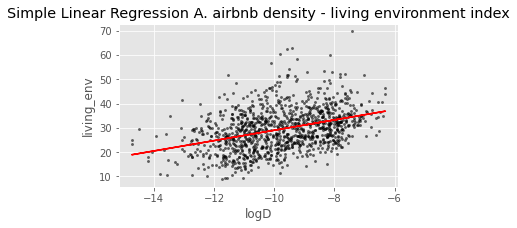

In [65]:
# import packages
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

# calculate parameter
lm = ols('living_env ~ logD', data=category2).fit()
A_reg = smf.ols(formula='living_env ~ logD',data=category2).fit()
beta_A1, beta_A2 = A_reg.params
rsq_A    = A_reg.rsquared
pval_A1, pval_A2 = A_reg.pvalues
print("Simple linear regression A. airbnb density - living environment index")
print("y =", round(beta_A2,3), "x +", round(beta_A1,3))
print("R^2 = ", rsq_A)
print("p-value of living_env = ", round(pval_A2,5))
print("p-value of intercept = ", round(pval_A1,5))

# plot scatter and regression line
fig, ax = plt.subplots()
category2.plot(kind='scatter', y='living_env', x='logD', figsize=(5, 3), ax = ax,s=5, alpha = 0.6, color = 'k')
plt.title(label = "Simple Linear Regression A. airbnb density - living environment index")
X = category2.logD
b = plt.plot(X, X*beta_A2 + beta_A1, 'r') # 回归线

R-squared is 0.145 which shows 14.5% values can be explained by the model. The p values are lower than 0.05. There is a linear relationship between airbnb density and living environment index. The higher the airbnb density (log), the higher the environmental deprivation index.

##### Regression B. X: airbnb density - Y: hous_serv

Simple linear regression B. airbnb density - housing serving index
y = -1.779 x + 21.125
R^2 =  0.11518704469201224
p-value of hous_serv =  0.0
p-value of intercept =  0.0


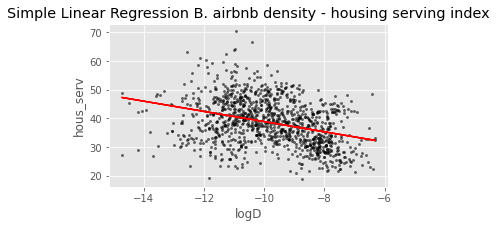

In [66]:
# calculate parameter
lm = ols('hous_serv ~ logD', data=category2).fit()
A_reg = smf.ols(formula='hous_serv ~ logD',data=category2).fit()
beta_A1, beta_A2 = A_reg.params
rsq_A    = A_reg.rsquared
pval_A1, pval_A2 = A_reg.pvalues
print("Simple linear regression B. airbnb density - housing serving index")
print("y =", round(beta_A2,3), "x +", round(beta_A1,3))
print("R^2 = ", rsq_A)
print("p-value of hous_serv = ", round(pval_A2,5))
print("p-value of intercept = ", round(pval_A1,5))

# plot scatter and regression line
fig, ax = plt.subplots()
category2.plot(kind='scatter', y='hous_serv', x='logD', figsize=(5, 3), ax = ax,s=5, alpha = 0.6, color = 'k')
plt.title(label = "Simple Linear Regression B. airbnb density - housing serving index")
X = category2.logD
b = plt.plot(X, X*beta_A2 + beta_A1, 'r') # 回归线

R-squared is 0.115 which shows 11.5% values can be explained by the model. The p values are lower than 0.05. There is a linear relationship between airbnb density and housing serving deprivation index. The higher the airbnb density (log), the lower the housing serving deprivation index.

##### Regression C. X: airbnb density - Y: edu_ski_tra

Simple linear regression C. Airbnb Density - Education Index
y = -2.415 x + 0.225
R^2 =  0.1986224547899751
p-value of edu_ski_tra =  0.0
p-value of intercept =  0.87568


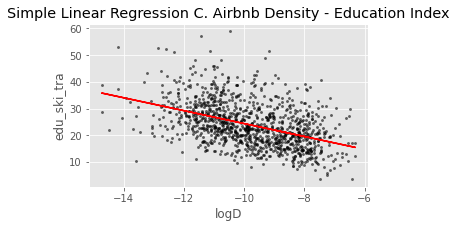

In [67]:
# calculate parameter
lm = ols('edu_ski_tra ~ logD', data=category2).fit()
A_reg = smf.ols(formula='edu_ski_tra ~ logD',data=category2).fit()
beta_A1, beta_A2 = A_reg.params
rsq_A    = A_reg.rsquared
pval_A1, pval_A2 = A_reg.pvalues
print("Simple linear regression C. Airbnb Density - Education Index")
print("y =", round(beta_A2,3), "x +", round(beta_A1,3))
print("R^2 = ", rsq_A)
print("p-value of edu_ski_tra = ", round(pval_A2,5))
print("p-value of intercept = ", round(pval_A1,5))

# plot scatter and regression line
fig, ax = plt.subplots()
category2.plot(kind='scatter', y='edu_ski_tra', x='logD', figsize=(5, 3), ax = ax,s=5, alpha = 0.6, color = 'k')
plt.title(label = "Simple Linear Regression C. Airbnb Density - Education Index")
X = category2.logD
b = plt.plot(X, X*beta_A2 + beta_A1, 'r') # 回归线

R-squared is 0.199 which shows 19.9% values can be explained by the model. The p values are lower than 0.05. There is a linear relationship between airbnb density and education deprivation index. The higher the airbnb density, the lower the housing serving deprivation index.

##### Regression D. X: airbnb density - Y: health_depri

Simple linear regression D. Airbnb Density - Health Deprivation Index
y = 0.085 x + 1.121
R^2 =  0.1161640436151603
p-value of health_depri =  0.0
p-value of intercept =  0.0


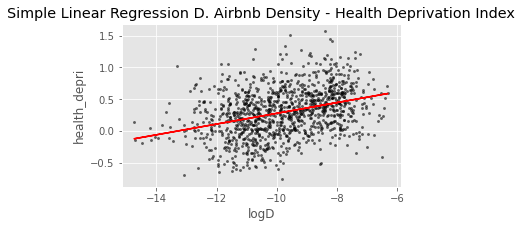

In [68]:
# calculate parameter
lm = ols('health_depri ~ logD', data=category2).fit()
A_reg = smf.ols(formula='health_depri ~ logD',data=category2).fit()
beta_A1, beta_A2 = A_reg.params
rsq_A    = A_reg.rsquared
pval_A1, pval_A2 = A_reg.pvalues
print("Simple linear regression D. Airbnb Density - Health Deprivation Index")
print("y =", round(beta_A2,3), "x +", round(beta_A1,3))
print("R^2 = ", rsq_A)
print("p-value of health_depri = ", round(pval_A2,5))
print("p-value of intercept = ", round(pval_A1,5))

# plot scatter and regression line
fig, ax = plt.subplots()
category2.plot(kind='scatter', y='health_depri', x='logD', figsize=(5, 3), ax = ax,s=5, alpha = 0.6, color = 'k')
plt.title(label = "Simple Linear Regression D. Airbnb Density - Health Deprivation Index")
X = category2.logD
b = plt.plot(X, X*beta_A2 + beta_A1, 'r') # 回归线

R-squared is 0.116 which shows 11.6% values can be explained by the model. The p values are lower than 0.05. There is a linear relationship between airbnb density and health deprivation index. The higher the airbnb density, the higher the housing serving deprivation index.

summary:
    
Living environment deprivation and health deprivation indexes show positive relationship with Airbnb density. Negative social influences caused by high-dense Airbnb were reflected on these indexes, which could because of the lack of collective identity and supervision. Residents are inclined to use their apartments for profit, instead of nurturing local culture and rootedness. For example, some investigations (Jokela and Minoia, 2020) suggested that ordinary houses used for tourism accommodation can lead to unsafety for its unregulated delivery of keys to Airbnb guests. Public Health Concerns in Airbnb Venues have been identified in many countries (Kennedy et al., 2018). Other countries found that the health regulation of Airbnb is weaker than that of hotels.

Areas with low value in education deprivation and housing serving deprivation index indicate high potential in Airbnb development in the future, which provide insights accordingly for regulation policy by area in advance. 

#### 2.3.3. Category 3: least deprived area

#### preparations for regression analysis

In [69]:
# it was selected based on cluster_id and na values were dropped
clu2.info()
clu2.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1374 entries, 0 to 4830
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LSOA11CD           1374 non-null   object  
 1   LSOA11NM           1374 non-null   object  
 2   MSOA11CD           1374 non-null   object  
 3   MSOA11NM           1374 non-null   object  
 4   LAD11CD            1374 non-null   object  
 5   LAD11NM            1374 non-null   object  
 6   RGN11CD            1374 non-null   object  
 7   RGN11NM            1374 non-null   object  
 8   USUALRES           1374 non-null   int64   
 9   HHOLDRES           1374 non-null   int64   
 10  COMESTRES          588 non-null    float64 
 11  POPDEN             1374 non-null   float64 
 12  HHOLDS             1374 non-null   int64   
 13  AVHHOLDSZ          1374 non-null   float64 
 14  area               1374 non-null   float64 
 15  summary            1374 non-null   float64 
 16

LSOA11CD             LSOA11NM   MSOA11CD            MSOA11NM    LAD11CD  \
0    E01000001  City of London 001A  E02000001  City of London 001  E09000001   
1    E01000002  City of London 001B  E02000001  City of London 001  E09000001   
112  E01000116          Barnet 009B  E02000032          Barnet 009  E09000003   
113  E01000117          Barnet 010A  E02000033          Barnet 010  E09000003   
115  E01000119          Barnet 009C  E02000032          Barnet 009  E09000003   

            LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  ...  \
0    City of London  E12000007  London      1465      1465  ...   
1    City of London  E12000007  London      1436      1436  ...   
112          Barnet  E12000007  London      1718      1718  ...   
113          Barnet  E12000007  London      1819      1819  ...   
115          Barnet  E12000007  London      1680      1680  ...   

     london_imd_decile                                      imd  \
0                   10                                   6.2080   
1                   10                                   5.1430   
112                  9                                   7.7900   
113                  9                                   9.6420   
115                  8                                  11.5890   

                                      income  \
0                                     0.0070   
1                                     0.0340   
112                                   0.0740   
113                                   0.0710   
115                                   0.0780   

                                  employment  \
0                                     0.0100   
1                                     0.0270   
112                                   0.0490   
113                                   0.0620   
115                                   0.0540   

                                 edu_ski_tra  \
0                                     0.0240   
1                                     0.0630   
112                                   3.8700   
113                                   6.0770   
115                                   3.3120   

                                health_depri  \
0                                    -1.6540   
1                                    -1.1150   
112                                  -1.4120   
113                                  -1.1410   
115                                  -1.8840   

                                       crime  \
0                                    -2.0120   
1                                    -2.3430   
112                                  -0.4300   
113                                  -0.1680   
115                                   0.6270   

                                   hous_serv  \
0                                    29.4720   
1                                    24.4120   
112                                  19.1730   
113                                  21.5060   
115                                  23.5190   

                                  living_env  cluster_names  
0                                    31.8730              3  
1                                    23.0840              3  
112                                  18.2480              3  
113                                  17.6600              3  
115                                  21.9490              3  

[5 rows x 36 columns]

In [70]:
#check and drop the irrelevant columns
print(clu2.columns) 
to_drop_col=['LSOA11CD', 'LSOA11NM','MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'area', 'summary',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', 'code', 'name','london_imd_rank', 'london_imd_decile',]
clu2_corr = clu2.drop(to_drop_col,axis=1)
print(clu2_corr.columns)

Index(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'area', 'summary', 'm_price', 'minimum_ni',
       'm_monrevie', 'm_hostlist', 'm_avaliabl', 'density', 'geometry', 'code',
       'name', 'london_imd_rank', 'london_imd_decile', 'imd', 'income',
       'employment', 'edu_ski_tra', 'health_depri', 'crime', 'hous_serv',
       'living_env', 'cluster_names'],
      dtype='object')
Index(['m_price', 'minimum_ni', 'm_monrevie', 'm_hostlist', 'm_avaliabl',
       'density', 'imd', 'income', 'employment', 'edu_ski_tra', 'health_depri',
       'crime', 'hous_serv', 'living_env', 'cluster_names'],
      dtype='object')


In this category, we can find neighbourhoods with low values for income, employment, crime, housing services and living environment deprivation index in London. These areas are also associated with higher prices, higher number of host listings and lower density of listings.

##### correlation matrix

In [71]:
# what is the Pearson correlation between IMD and Airbnb?
cor = clu2_corr.corr()
cor.style.background_gradient(cmap='coolwarm')

summary


strong positive correlationship
    living_env ～ Airbnb density
    
moderate positive correlationship
    living_env ～ Airbnb price
    
moderate negative correlationship
    employment ～ Airbnb price
    health_depri ～ Airbnb price
    
The coefficient of vairiables above are relatively higher, therefore, these vairiables are selected to build the model.Further exploration of the relationship between these variables is presented below.

#### Regression Analysis

##### Check the data distribution

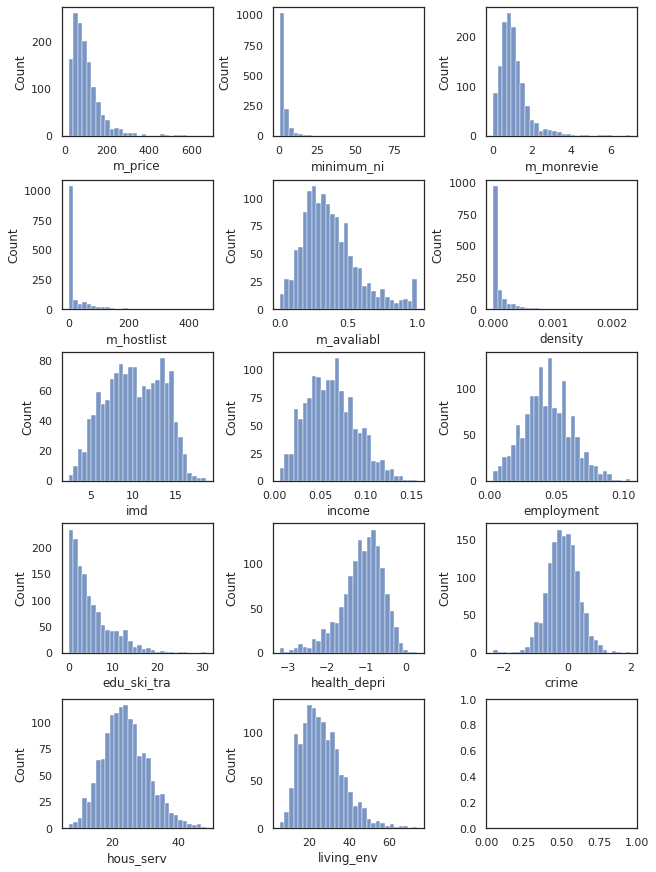

In [72]:
import seaborn as sns
sns.set(style='white')
df = clu2_corr
fig, ax =plt.subplots(5,3,constrained_layout=True, figsize=(9, 12))
for i in range(0,14):
      # print(i)
      axs=sns.histplot(data=df,x=df.columns[i],bins=30,ax=ax[int(i/3)][i%3])
      #axs.set_title('{}'.format(df.columns[i]))
      #print(df.columns[i])

plt.show()

density, price, hostlist, health_depri, living_env - These variables have significant skew and tend to affect the results of the regression analysis, so we need to perform a log transformation before conducting the analysis

##### Regression A. X: airbnb density, price, hostlist - Y: living_env

In [73]:
# Prepare data for multiple linear regression
to_drop_col=['m_monrevie', 'minimum_ni', 'imd', 'income', 'employment', 'edu_ski_tra', 'health_depri',
       'crime', 'hous_serv','m_avaliabl']
to_drop_col2=['m_monrevie', 'minimum_ni', 'imd', 'income', 'employment', 'edu_ski_tra', 'health_depri',
       'crime', 'hous_serv', 'living_env','m_avaliabl']
clu2_vif = clu2_corr.drop(to_drop_col2,axis=1) # Dataframe for vif
clu2_vif.columns #Check the vif variables

Index(['m_price', 'm_hostlist', 'density', 'cluster_names'], dtype='object')

In [74]:
# preparation for regression analysis - log transformation
log = np.log(clu2_corr['m_price'])
clu2_vif['logprice']=log

log = np.log(clu2_corr['density'])
clu2_vif['logden']=log

log = np.log(clu2_corr['m_hostlist'])
clu2_vif['loghl']=log

clu2_vif_log = clu2_vif[['logprice', 'logden', 'loghl']]
clu2_re = np.log(clu2_corr[['living_env']])
clu2_re = clu2_re.rename(columns = {"living_env":"logliving_env"})

In [75]:
clu2_re

logliving_env
0                                      3.4618
1                                      3.1391
112                                    2.9041
113                                    2.8713
115                                    3.0887
...                                       ...
4812                                   3.1486
4816                                   3.0802
4819                                   3.2892
4824                                   2.8640
4830                                   2.5268

[1374 rows x 1 columns]

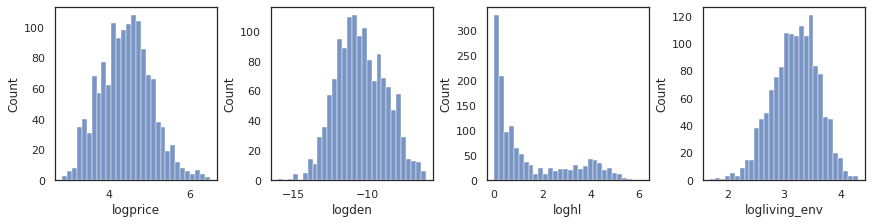

In [76]:
#plot log-transformed 
import seaborn as sns
sns.set(style='white')
df = clu2_vif_log
fig, ax =plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
for i in range(0,3):
      #print(i)
      axs=sns.histplot(data=df,x=df.columns[i],bins=30,ax=ax[i%4])
      #axs.set_title('{}'.format(df.columns[i]))
      #print(df.columns[i])

ax4=sns.histplot(data=clu2_re,x=clu2_re.columns[0],bins=30,ax=ax[3%4])
plt.show()

In [77]:
# test VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df




In [78]:
#test vif
df_selected_VIF = drop_column_using_vif_(clu2_vif_log)
print("The columns remaining after VIF selection are:")
print(df_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['logprice', 'logden', 'loghl'], dtype='object')


                            OLS Regression Results                            
Dep. Variable:          logliving_env   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     485.6
Date:                Wed, 18 Jan 2023   Prob (F-statistic):          7.14e-215
Time:                        15:07:59   Log-Likelihood:                -212.75
No. Observations:                1374   AIC:                             433.5
Df Residuals:                    1370   BIC:                             454.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4570      0.111     40.100      0.0

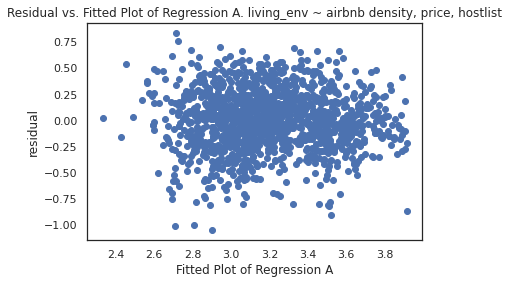

In [79]:
# conduct regression
import statsmodels.api as sm
clu2_envre = sm.OLS(endog=clu2_re['logliving_env'], exog=sm.add_constant(clu2_vif_log)).fit()
print(clu2_envre.summary())

# Check residuals for the model
# plot 
plt.scatter(clu2_envre.fittedvalues,clu2_envre.resid)
# adding title and labels
plt.xlabel('Fitted Plot of Regression A')
plt.ylabel('residual')
plt.title('Residual vs. Fitted Plot of Regression A. living_env ~ airbnb density, price, hostlist')
plt.show()

R-squared is 0.515 which shows 51.5% explaining the model. The p values of logprice, logdensity are lower than 0.05. There are relationships between logprice, logdensity and living environment. Due to the high p-value of the hostlist variable will not be explored in the subsequent analysis.

The higher the price and density, the higher the environmental deprivation index.

##### Regression B. X: airbnb price - Y: health_depri 

In [80]:
# preparation for regression analysis - log transformation
df_test = clu2_vif_log
df_test['loghealth_depri'] = np.log(clu2_corr[['health_depri']] + 4.215)
df_test

/tmp/ipykernel_1957/2794632424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['loghealth_depri'] = np.log(clu2_corr[['health_depri']] + 4.215)


logprice  \
0                                      5.0184   
1                                      5.3003   
112                                    3.7917   
113                                    3.2387   
115                                    4.0741   
...                                       ...   
4812                                   3.8607   
4816                                   4.3278   
4819                                   4.3718   
4824                                   4.7283   
4830                                   3.7034   

                                       logden  \
0                                     -8.9673   
1                                    -10.0266   
112                                  -11.3117   
113                                  -12.0118   
115                                  -10.5979   
...                                       ...   
4812                                 -12.2038   
4816                                  -9.0328   
4819                                  -8.5952   
4824                                  -8.1893   
4830                                  -9.2375   

                                        loghl  \
0                                      3.2738   
1                                      1.5686   
112                                    0.0000   
113                                    0.0000   
115                                    1.0296   
...                                       ...   
4812                                   0.6931   
4816                                   2.0223   
4819                                   0.4321   
4824                                   0.9217   
4830                                   0.2877   

                              loghealth_depri  
0                                      0.9404  
1                                      1.1314  
112                                    1.0307  
113                                    1.1230  
115                                    0.8463  
...                                       ...  
4812                                   1.2823  
4816                                   1.2698  
4819                                   1.0733  
4824                                   1.3600  
4830                                   1.3405  

[1374 rows x 4 columns]

                            OLS Regression Results                            
Dep. Variable:        loghealth_depri   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     194.1
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           2.33e-41
Time:                        15:07:59   Log-Likelihood:                 340.75
No. Observations:                1374   AIC:                            -677.5
Df Residuals:                    1372   BIC:                            -667.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6111      0.036     44.745      0.0

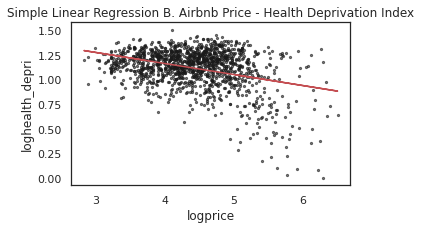

In [81]:
# import packages
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

# calculate parameter
lm = ols('loghealth_depri ~ logprice', data=df_test).fit()
A_reg = smf.ols(formula='loghealth_depri ~ logprice',data=df_test).fit()
print(A_reg.summary())

beta_A1, beta_A2 = A_reg.params
rsq_A    = A_reg.rsquared
pval_A1, pval_A2 = A_reg.pvalues
print("Simple Linear Regression B. Airbnb Price - Health Deprivation Index")
print("y =", round(beta_A2,3), "x +", round(beta_A1,3))
print("R^2 = ", rsq_A)
print("p-value of living_env = ", round(pval_A2,5))
print("p-value of intercept = ", round(pval_A1,5))

# plot scatter and regression line
fig, ax = plt.subplots()
df_test.plot(kind='scatter', x='logprice', y='loghealth_depri', figsize=(5, 3), ax = ax,s=5, alpha = 0.6, color = 'k')
plt.title(label = "Simple Linear Regression B. Airbnb Price - Health Deprivation Index")
X = df_test.logprice
b = plt.plot(X, X*beta_A2 + beta_A1, 'r') # 回归线

R-squared is 0.124 which shows 12.4% explaining the model. The p values of logprice is lower than 0.05. There are relationships between logprice and health deprivation index. 

The higher the price the lower the health deprivation index, the better the health of the area

##### Regression C. X: airbnb price - Y: employment

In [82]:
# preparation for regression analysis - log transformation
df_test = clu2_vif_log
df_test['logemployment'] = np.log(clu2_corr[['employment']])
df_test

/tmp/ipykernel_1957/3810613079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['logemployment'] = np.log(clu2_corr[['employment']])


logprice  \
0                                      5.0184   
1                                      5.3003   
112                                    3.7917   
113                                    3.2387   
115                                    4.0741   
...                                       ...   
4812                                   3.8607   
4816                                   4.3278   
4819                                   4.3718   
4824                                   4.7283   
4830                                   3.7034   

                                       logden  \
0                                     -8.9673   
1                                    -10.0266   
112                                  -11.3117   
113                                  -12.0118   
115                                  -10.5979   
...                                       ...   
4812                                 -12.2038   
4816                                  -9.0328   
4819                                  -8.5952   
4824                                  -8.1893   
4830                                  -9.2375   

                                        loghl  \
0                                      3.2738   
1                                      1.5686   
112                                    0.0000   
113                                    0.0000   
115                                    1.0296   
...                                       ...   
4812                                   0.6931   
4816                                   2.0223   
4819                                   0.4321   
4824                                   0.9217   
4830                                   0.2877   

                              loghealth_depri  \
0                                      0.9404   
1                                      1.1314   
112                                    1.0307   
113                                    1.1230   
115                                    0.8463   
...                                       ...   
4812                                   1.2823   
4816                                   1.2698   
4819                                   1.0733   
4824                                   1.3600   
4830                                   1.3405   

                                logemployment  
0                                     -4.6052  
1                                     -3.6119  
112                                   -3.0159  
113                                   -2.7806  
115                                   -2.9188  
...                                       ...  
4812                                  -3.6889  
4816                                  -3.5405  
4819                                  -3.9120  
4824                                  -4.6052  
4830                                  -3.2189  

[1374 rows x 5 columns]

                            OLS Regression Results                            
Dep. Variable:          logemployment   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     293.2
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           1.03e-59
Time:                        15:07:59   Log-Likelihood:                -851.03
No. Observations:                1374   AIC:                             1706.
Df Residuals:                    1372   BIC:                             1717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7782      0.086    -20.745      0.0

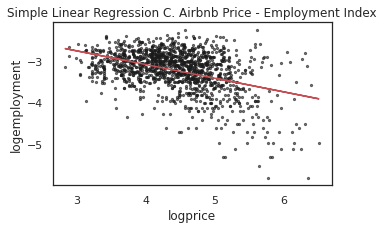

In [83]:
# import packages
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

# calculate parameter
lm = ols('logemployment ~ logprice', data=df_test).fit()
A_reg = smf.ols(formula='logemployment ~ logprice',data=df_test).fit()
print(A_reg.summary())

beta_A1, beta_A2 = A_reg.params
rsq_A    = A_reg.rsquared
pval_A1, pval_A2 = A_reg.pvalues
print("Simple linear regression C. employment index - logprice")
print("y =", round(beta_A2,3), "x +", round(beta_A1,3))
print("R^2 = ", rsq_A)
print("p-value of living_env = ", round(pval_A2,5))
print("p-value of intercept = ", round(pval_A1,5))

# plot scatter and regression line
fig, ax = plt.subplots()
df_test.plot(kind='scatter', x='logprice', y='logemployment', figsize=(5, 3), ax = ax,s=5, alpha = 0.6, color = 'k')
plt.title(label = "Simple Linear Regression C. Airbnb Price - Employment Index")
X = df_test.logprice
b = plt.plot(X, X*beta_A2 + beta_A1, 'r')

R-squared is 0.176 which shows 17.6% explaining the model. The p values of logprice is lower than 0.05. There are relationships between logprice and employment deprivation index.

The higher the price, the lower the employment deprivation index and the better the employment situation

summary

In the least deprived category 3, there is a positive correlation between the density, price ofAirbnb listings and living environment deprivation. This highlights the negative impact thathigh-density, better-conditioned listings can have on the surrounding community, includingissues such as traffic congestion, and other disturbances (e.g. pollution, noise, damage to indoorenvironment) to the whole residential area by the rude and noisy behaviour of some visitors.(Wegmann and Jiao, 2017)

Conversely, health and employment deprivation are found to have a negative correlation withAirbnb listings price, indicating that listings generate higher incomes tend to be provided byindividuals who are able-bodied and employed. This could reveal the income inequalities thatmay be perpetuated by Airbnb, and the subsequent impact on health and employment opportu-nities for residents. (Balampanidis et al., 2021) It is important to note that low-priced Airbnblistings, while potentially poorer in terms of location or living experience, can still offer priceadvantages. Therefore, it is recommended that policy measures be implemented to guide the de-velopment of these listings and promote employment and health outcomes for residents. (Suess,Woosnam and Erul, 2020)

### 2.4 What kind of neighborhoods require regulation in Airbnb operation?

#### 2.4.1. Category 1: partially deprived area
Neighborhoods of category 1 will be filtered based on its imd sub-index value analysed in _2.3_.

Future Airbnb Guidance with borough map

<Figure size 432x288 with 0 Axes>

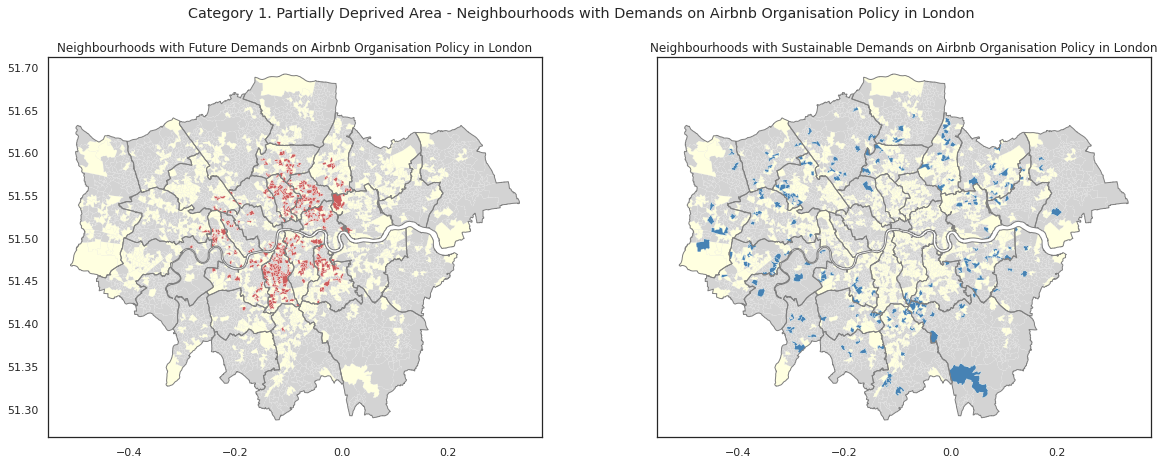

In [99]:
# Select neighborhoodds with high Airbnb density, high values in living_env index and low availability of Airbnb
H_Living = clu0[clu0['living_env'] > clu0['living_env'].median()]
H_D = clu0[clu0['density'] > clu0['density'].median()]
L_A = clu0[clu0['m_avaliabl'] < clu0['m_avaliabl'].median()]
M0 = H_Living.merge(H_D, on = [ 'LSOA11CD'], how = 'inner')
restriction0 = M0.merge(L_A, on = [ 'LSOA11CD'], how = 'inner')
restriction = restriction0[['LSOA11CD']]

# join spatial data to neighbourhoods 
LSOAairbnb.to_crs(epsg=27700).plot(ax=ax1, color='lightgrey')

clu0map = clu0[['LSOA11CD']]
clu0map1 = LSOAairbnb.merge(clu0map, on='LSOA11CD', how='inner')

Borough = gpd.read_file("https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true")

fig, (ax1, ax2) = pyplot.subplots(ncols=2, figsize = (20,7), sharex=True, sharey=True)



restrictionmap = LSOAairbnb.merge(restriction, on='LSOA11CD', how='inner')

# Select neighborhoodds with low Airbnb density, low values in living_env index index and high availability
L_Living = clu0[clu0['living_env'] < clu0['living_env'].median()]
L_D = clu0[clu0['density'] < clu0['density'].median()]
L_A = clu0[clu0['m_avaliabl'] < clu0['m_avaliabl'].median()]

# extract future neighborhood
I0 = L_Living.merge(L_D, on = [ 'LSOA11CD'], how = 'inner')
improvment0 = I0.merge(L_A, on = [ 'LSOA11CD'], how = 'inner')
improvment = improvment0[['LSOA11CD']]

# join spatial data to neighbourhoods 
improvementmap = LSOAairbnb.merge(improvment, on='LSOA11CD', how='inner')

# Overall Map

LSOAairbnb.plot(ax=ax1, color= 'lightgrey', edgecolor="white", linewidth=.05)
clu0map1.plot(ax=ax1, color= 'lightyellow', edgecolor="white", linewidth=.05)
restrictionmap.plot(ax=ax1, color= 'indianred', edgecolor="white", linewidth=.2)
Borough.to_crs(epsg=4326).plot(ax=ax1, facecolor='none', edgecolor="grey",linewidth=1)
ax1.set_title('Neighbourhoods with Future Demands on Airbnb Organisation Policy in London')



LSOAairbnb.plot(ax=ax2, color= 'lightgrey', edgecolor="white", linewidth=.05)
clu0map1.plot(ax=ax2, color= 'lightyellow', edgecolor="white", linewidth=.05)
improvementmap.plot(ax=ax2, color= 'steelblue', edgecolor="white", linewidth=.2)
Borough.to_crs(epsg=4326).plot(ax=ax2, facecolor='none', edgecolor="grey",linewidth=1)
ax2.set_title('Neighbourhoods with Sustainable Demands on Airbnb Organisation Policy in London')

fig.suptitle('Category 1. Partially Deprived Area - Neighbourhoods with Demands on Airbnb Organisation Policy in London')
plt.savefig('Future development demand in London: category 1')

#### 2.4.2. Category 2: most deprived area
Neighborhoods of category 2 will be filtered based on its imd sub-index value analysed in _2.3_.

##### A. areas with high density of airbnb and high living_env + health depri index

Interventions for airbnb operation are needed to deal with current social issues.

In [87]:
# Select neighborhoodds with high Airbnb density and high values in living_env and health_depri index
H_LE2 = category2[category2['living_env'] > category2['living_env'].median()]
H_HD2 = category2[category2['health_depri'] > category2['health_depri'].median()]
H_D2 = category2[category2['density'] > category2['density'].median()]
M0 = H_LE2.merge(H_HD2, on = [ 'LSOA11CD'], how = 'inner')
Need2 = M0.merge(H_D2, on = [ 'LSOA11CD'], how = 'inner')
Need2 = Need2[['LSOA11CD']]

In [88]:
# join spatial data to neighbourhoods with issues in living environment and health deprivation
needmap2 = LSOAairbnb.merge(Need2, on='LSOA11CD', how='inner')
category2map = category2[['LSOA11CD']]
category2map = LSOAairbnb.merge(category2map, on='LSOA11CD', how='inner')

##### B. areas with low density of airbnb and low edu_ski_tra + hous_serv index

Pre-instructions for airbnb operation should be proposed to avoid adverse future consequences.

In [89]:
# Select neighborhoodds with low Airbnb density and low values in edu_ski_tra and hous_serv index
L_EDU2 = category2[category2['edu_ski_tra'] < category2['edu_ski_tra'].median()]
L_HS2 = category2[category2['hous_serv'] < category2['hous_serv'].median()]
L_D2 = category2[category2['density'] < category2['density'].median()]
# extract future neighborhood
F0 = L_EDU2.merge(L_HS2, on = [ 'LSOA11CD'], how = 'inner')
future2 = F0.merge(L_D2, on = [ 'LSOA11CD'], how = 'inner')
future2 = future2[['LSOA11CD']]

In [90]:
# join spatial data to neighbourhoods with issues in living environment and health deprivation
futuremap2 = LSOAairbnb.merge(future2, on='LSOA11CD', how='inner')

Text(0.5, 0.98, 'Category 2. Most Deprived Area - Neighbourhoods with Demands on Airbnb Organisation Policy in London')

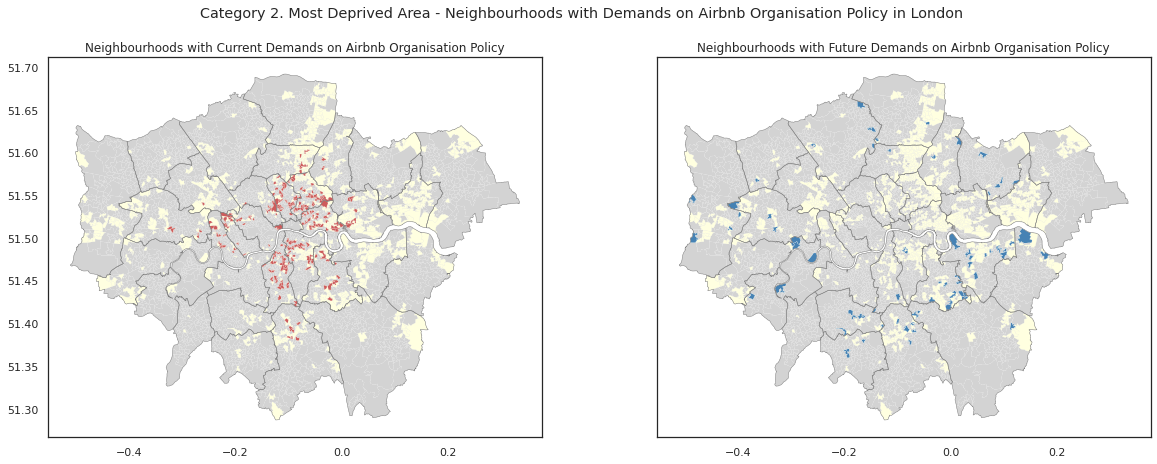

In [91]:
from matplotlib import pyplot
import geopandas
from shapely import geometry

# read borough boundary
Borough = gpd.read_file("https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true")

fig, (ax1, ax2) = pyplot.subplots(ncols=2, figsize = (20,7), sharex=True, sharey=True)

# ax1 Neighbourhoods with Current Demands on Airbnb Organisation Policy
LSOAairbnb.plot(ax=ax1, color= 'lightgrey', edgecolor="white", linewidth=.05)
category2map.plot(ax=ax1, color= 'lightyellow', edgecolor="white", linewidth=.05)
needmap2.plot(ax=ax1,  color= 'indianred', edgecolor="white", linewidth=.1)
Borough.to_crs(epsg=4326).plot(ax=ax1, facecolor='none', edgecolor="grey",linewidth=0.5)
ax1.set_title('Neighbourhoods with Current Demands on Airbnb Organisation Policy')

# ax2 Neighbourhoods with Demands on Airbnb Organisation Policy in London
LSOAairbnb.plot(ax=ax2, color= 'lightgrey', edgecolor="white", linewidth=.05)
category2map.plot(ax=ax2, color= 'lightyellow', edgecolor="white", linewidth=.05)
futuremap2.plot(ax=ax2, color= 'steelblue', edgecolor="white", linewidth=.2)
Borough.to_crs(epsg=4326).plot(ax=ax2, facecolor='none', edgecolor="grey",linewidth=0.5)
ax2.set_title('Neighbourhoods with Future Demands on Airbnb Organisation Policy')

fig.suptitle('Category 2. Most Deprived Area - Neighbourhoods with Demands on Airbnb Organisation Policy in London')

Neighbourhoods highlighted in the left map have higher living environment deprivation index and health deprivation index. Most of these neighbourhoods are in the inner London boroughs. To deal with the living environment deprivation, residential community and Airbnb accommodation should be clearly differentiated for better Airbnb operation with new regulation policy. The health and sanitary policy are supposed to be clarified especially for Airbnb accommodation. A monitoring strategy for Airbnb operation by neighbourhood can be applied to alleviate its advert impact in time (Li and Canelles, 2021).

Another map shows some neighbourhoods with a developing trend of Airbnb for its strengths in housing serving and trainning comparing with other areas. Most of these neighbourhoods are in the outer London boroughs. Low housing serving deprivation index represents abundant housing sources. As emerging Airbnb units located in residential areas may lead to potential conflict with housing market, precautionary strategies should be proposed to instruct Airbnb development in these areas.

#### 2.4.3. Category 3: least deprived area
Neighborhoods of category 3 will be filtered based on its imd sub-index value analysed in 2.3.

##### A. areas with high density, price of airbnb and high living_environment index

In [92]:
# Select neighborhoodds with high Airbnb density, price and high values living_env index
H_LE3 = clu2[clu2['living_env'] > clu2['living_env'].median()]
H_PR3 = clu2[clu2['m_price'] > clu2['m_price'].median()]
H_D3 = clu2[clu2['density'] > clu2['density'].median()]
M0 = H_LE3.merge(H_PR3, on = [ 'LSOA11CD'], how = 'inner')
Need3 = M0.merge(H_D3, on = [ 'LSOA11CD'], how = 'inner')
Need3 = Need3[['LSOA11CD']]

In [93]:
# join spatial data to neighbourhoods with issues in living environment deprivation
'''
joined = pd.read_csv('./LSOAairbnbclu.csv')
LSOAairbnb = gpd.read_file('./densityshapefile5.1yue/LSOAairbnb.shp')
LSOAairbnb['density'] = LSOAairbnb['summary']/LSOAairbnb['area']
LSOAairbnb['living_env'] = joined['living_env']
'''
needmap3 = LSOAairbnb.merge(Need3, on='LSOA11CD', how='inner')
clu2map = clu2[['LSOA11CD']]
clu2map = LSOAairbnb.merge(clu2map, on='LSOA11CD', how='inner')

Areas requiring environmental regulatory measures for Airbnb's operations

##### B. areas with low price of airbnb and low employment, health deprive index

In [94]:
# Select neighborhoodds with low Airbnb price and low values in employment and health deprivation

L_HD3 = clu2[clu2['health_depri'] > clu2['health_depri'].median()]
L_EP3 = clu2[clu2['employment'] > clu2['employment'].median()]
L_D3 = clu2[clu2['m_price'] < clu2['m_price'].median()]
# extract future neighborhood
F0 = L_HD3.merge(L_EP3, on = [ 'LSOA11CD'], how = 'inner')
future3 = F0.merge(L_D3, on = [ 'LSOA11CD'], how = 'inner')
future3 = future3[['LSOA11CD']]

In [95]:
# join spatial data to neighbourhoods with issues in living employment and health deprivation
futuremap3 = LSOAairbnb.merge(future3, on='LSOA11CD', how='inner')

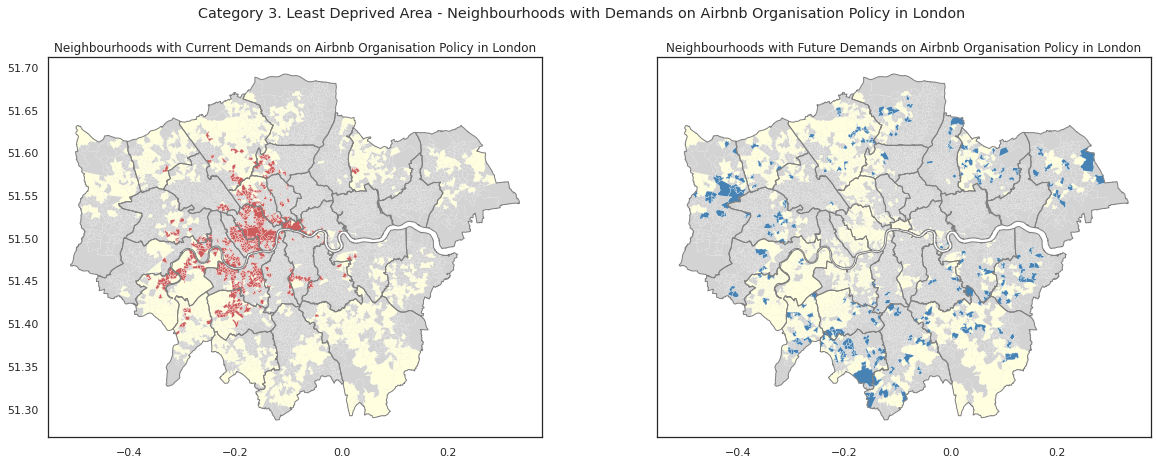

In [96]:
# plot
from matplotlib import pyplot
import geopandas
from shapely import geometry


Borough = gpd.read_file("https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true")
fig, (ax1, ax2) = pyplot.subplots(ncols=2, figsize = (20,7), sharex=True, sharey=True)

# ax1 Neighbourhoods with Current Demands on Airbnb Organisation Policy
LSOAairbnb.plot(ax=ax1, color= 'lightgrey', edgecolor="white", linewidth=.05)
clu2map.plot(ax=ax1, color= 'lightyellow', edgecolor="white", linewidth=.05)
needmap3.plot(ax=ax1, color= 'indianred', edgecolor="white", linewidth=.2)
Borough.to_crs(epsg=4326).plot(ax=ax1, facecolor='none', edgecolor="grey",linewidth=1)
ax1.set_title('Neighbourhoods with Current Demands on Airbnb Organisation Policy in London')

# ax2 Neighbourhoods with Demands on Airbnb Organisation Policy in London
LSOAairbnb.plot(ax=ax2, color= 'lightgrey', edgecolor="white", linewidth=.05)
clu2map.plot(ax=ax2, color= 'lightyellow', edgecolor="white", linewidth=.05)
futuremap3.plot(ax=ax2, color= 'steelblue', edgecolor="white", linewidth=.2)
Borough.to_crs(epsg=4326).plot(ax=ax2, facecolor='none', edgecolor="grey",linewidth=1)
ax2.set_title('Neighbourhoods with Future Demands on Airbnb Organisation Policy in London')

fig.suptitle('Category 3. Least Deprived Area - Neighbourhoods with Demands on Airbnb Organisation Policy in London')
plt.savefig('Neighbourhoods with Demands on Airbnb Organisation Policy in London')

The category 3 areas shown on the left , has a high living environment
deprivation index and Airbnb listings with high density and prices. These neighborhoods are primarily located on the west side of Inner London and require immediate
attention. To counteract living environment deprivation, regulations such as limiting the number of Airbnb listings, reducing the length of rentals, and increasing tax
transfer into environmental management, as proposed by Wegmann and Jiao (2017),
could be implemented.

On the other hand, the category 3 areas in Outer London, as shown on the right map,
have the advantage of low-cost development but suffer from more severe health and
employment deprivation, which could be mitigated by regulating Airbnb’s overall
operations. In the US, Davidson and Infranca (2015) has suggested that differentiating regulations and implementing possible redistribution mechanisms for Airbnb
at different prices could guide the development of low-priced Airbnb and increase
employment opportunities. (Moreno-Izquierdo et al., 2019) Additionally, contrary
to popular belief, research suggests that when the economic benefits of Airbnb development are translated into improved community infrastructure and enhanced
employment opportunities, the physical and mental health of residents can be improved.(Suess, Woosnam and Erul, 2020)

#### Combine the maps above in chapter 2.4

In [97]:
#current demand
#category 1
restrictionmap['legendcurrent'] = 'LSOAs with current demands (Category 1)'
#category 2
needmap2['legendcurrent'] = 'LSOAs with current demands (Category 2)'
#category 3
needmap3['legendcurrent'] = 'LSOAs with current demands (Category 3)'
#combine
current_bind = pd.concat([restrictionmap, needmap2, needmap3])


#future demand
#category 1
improvementmap['legendfuture'] = 'LSOAs with future risks (Category 1)'
#category 2
futuremap2['legendfuture'] = 'LSOAs with future risks (Category 2)'
#catogory 3
futuremap3['legendfuture'] = 'LSOAs with future risks (Category 3)'
future_bind = pd.concat([improvementmap,futuremap2, futuremap3])

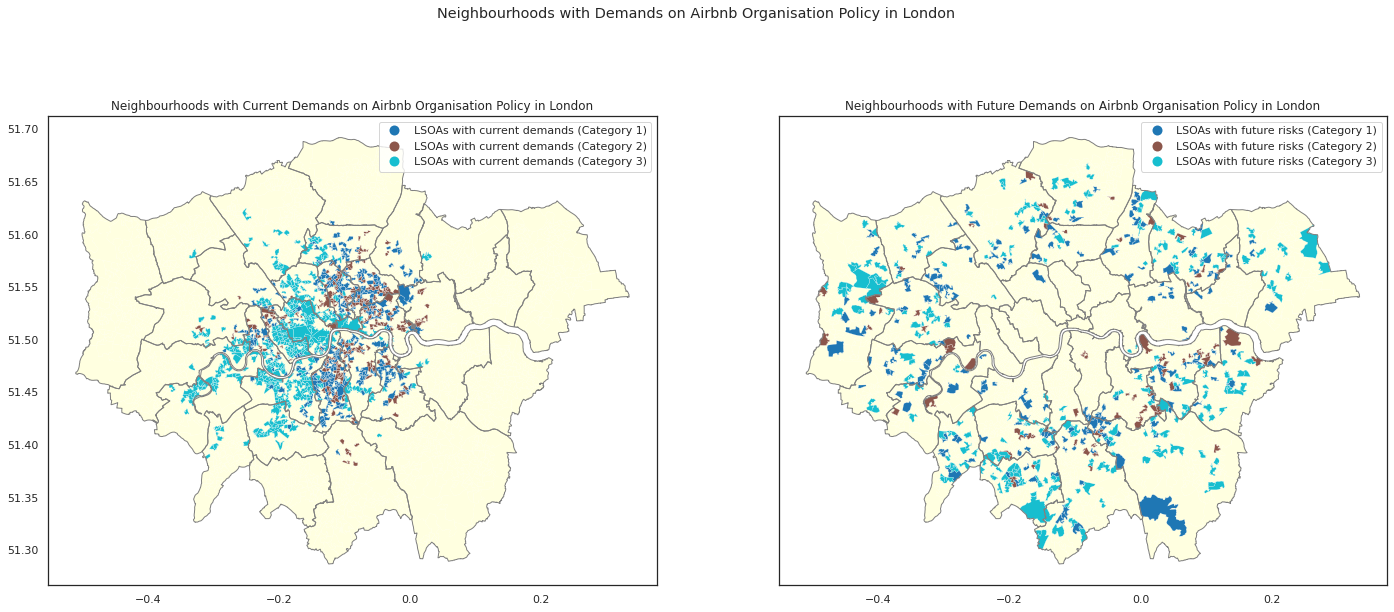

In [100]:

fig, (ax1, ax2) = pyplot.subplots(ncols=2, figsize = (24,10), sharex=True, sharey=True)

# ax1 Neighbourhoods with Current Demands on Airbnb Organisation Policy
LSOAairbnb.plot(ax=ax1, color= 'lightyellow', edgecolor="white", linewidth=.05)
current_bind.plot(ax=ax1 , column = 'legendcurrent', legend = True, edgecolor="white",linewidth=.2)
Borough.to_crs(epsg=4326).plot(ax=ax1, facecolor='none', edgecolor="grey",linewidth=1)
ax1.set_title('Neighbourhoods with Current Demands on Airbnb Organisation Policy in London')

# ax2 Neighbourhoods with Demands on Airbnb Organisation Policy in London
LSOAairbnb.plot(ax=ax2, color= 'lightyellow', edgecolor="white", linewidth=.05)
future_bind.plot(ax=ax2 , column = 'legendfuture', legend = True, edgecolor="white",linewidth=.2)
Borough.to_crs(epsg=4326).plot(ax=ax2, facecolor='none', edgecolor="grey",linewidth=1)
ax2.set_title('Neighbourhoods with Future Demands on Airbnb Organisation Policy in London')

fig.suptitle('Neighbourhoods with Demands on Airbnb Organisation Policy in London')
plt.savefig('Neighbourhoods with Demands on Airbnb Organisation Policy in London')
